# Visualize speed-dependent locomotion results

### Brandon Pratt, Updated 04/24/2023

Goal: visualize kinematic parameters as a function of walking speed and heading angle

### import python libraries

In [1]:
# python libraries
import os
from os import listdir
from os.path import isfile, join
import math

%matplotlib inline
import matplotlib.pyplot as plt
import ptitprince as pt
import matplotlib.colors as colors
import matplotlib.patches as  mpatches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import seaborn as sea
from scipy import interpolate
from scipy.stats import vonmises
from scipy.stats import iqr
from scipy.stats import mode
from scipy import stats
from scipy.stats import norm, lognorm, gamma, powerlaw, pearsonr
from sklearn.metrics import r2_score
from matplotlib.cbook import boxplot_stats


### load kinematic results

#### Load in Linear Treadmill data

In [2]:
genotype = 'wt_berlin'#'iav_kir'#'wt_berlin' 
genotype_plot_name = 'wt berlin' #'iav_kir'#'wt berlin'

# genotype = '52A01_DBD_tnt'#''52A01_DBD_tnt' fastest forward walking speed reported (49.63)
# genotype_plot_name = '52A01_DBD_tnt' #'iav_kir'#'wt berlin'

results_dir = 'C:/Users/pratt/Desktop/Analysis/LINEAR_BELT_RESULTS/results/'
#figure_dir = 'H:/.shortcut-targets-by-id/10pxdlRXtzFB-abwDGi0jOGOFFNm3pmFK/Tuthill Lab Shared/Brandon/Analysis/LINEAR_BELT_RESULTS/figures/'+ genotype_plot_name+'/'
figure_dir = 'H:/.shortcut-targets-by-id/10pxdlRXtzFB-abwDGi0jOGOFFNm3pmFK/Tuthill Lab Shared/manuscripts/treadmill_2023/figures/raw/'+ genotype_plot_name+'/linear_treadmill/'

# meta variables
meta_matrix = np.load(results_dir + genotype + '_meta_matrix.npy', allow_pickle=True)
beh_class = np.load(results_dir + genotype + '_behavior_classification.npy', allow_pickle=True)
heading_angle = np.load(results_dir + genotype + '_heading_angle.npy', allow_pickle=True)
position_probability = np.load(results_dir + genotype + '_position_probability.npy', allow_pickle=True)
parallel_vel = np.load(results_dir + genotype + '_parallel_velocity.npy', allow_pickle=True)
body_height_walking = np.load(results_dir + genotype + '_body_height_walking.npy', allow_pickle=True)
step_distance = np.load(results_dir + genotype + '_step_distance.npy', allow_pickle=True)
step_length = np.load(results_dir + genotype + '_step_length.npy', allow_pickle=True)

'''DOWNSAMPLED'''
# step_freq = np.load(results_dir + genotype + '_step_frequency.npy', allow_pickle=True)
# stance_duration = np.load(results_dir + genotype + '_stance_duration.npy', allow_pickle=True)
# swing_duration = np.load(results_dir + genotype + '_swing_duration.npy', allow_pickle=True) 

'''UPSAMPLED'''
step_freq = np.load(results_dir + genotype + '_upsampled_step_frequency.npy', allow_pickle=True)
stance_duration = np.load(results_dir + genotype + '_upsampled_stance_duration.npy', allow_pickle=True)
swing_duration = np.load(results_dir + genotype + '_upsampled_swing_duration.npy', allow_pickle=True) 

phase = np.load(results_dir + genotype + '_phase.npy', allow_pickle=True)
nlegs_stance_walking = np.load(results_dir + genotype + '_number_legs_in_stance_walking.npy', allow_pickle=True)
body_positions = np.load(results_dir + genotype + '_body_positions.npy', allow_pickle=True)
total_velocity = np.load(results_dir + genotype + '_total_velocity.npy', allow_pickle=True)

#### max walking velocity in mm/s - for R52A01 DVD > tnt

In [7]:
transformed_vel = np.copy(parallel_vel)
for j in range(meta_matrix.shape[0]):
    transformed_vel[j,:] = transformed_vel[j,:] * meta_matrix[j,-1] 
fw_vel = transformed_vel.flatten()[beh_class.flatten()==1]
print(np.max(fw_vel[~np.isnan(fw_vel)]))

49.632015378632815


In [24]:
# get meta data for max value
max_vel = np.zeros(meta_matrix.shape[0])
for j in range(meta_matrix.shape[0]):
    vel_mm = parallel_vel[j,:] * meta_matrix[j,-1]
    if len(vel_mm[beh_class[j,:]==1]) > 0:
        max_vel[j] = np.max(vel_mm[beh_class[j,:]==1])
print('max vel= ', max_vel[np.argmax(max_vel)])
print('max vel idx = ', np.argmax(max_vel))
print('Meta Info = ', meta_matrix[np.argmax(max_vel),:])

max vel=  49.632015378632815
max vel idx =  652
Meta Info =  [ 9.         74.         17.9         0.12944444  2.19172634]


In [26]:
np.where(transformed_vel[652, :]==49.632015378632815)[0]

array([1608], dtype=int64)

### Position Probability

In [48]:
FS = 180
chamber_position_bins = np.linspace(0, 8.929, 20)
bin_centers = np.round(chamber_position_bins[0:-1] + ((chamber_position_bins[1] - chamber_position_bins[0])/2), 2)
tx = np.transpose(np.copy(body_positions[3,:,:]))
trial_adj = np.array([0, FS, FS*2, FS*3, FS*4])
for j in range(tx.shape[0]):
    tx[j,:] = tx[j,:] * meta_matrix[j,-1]
driving_speeds = np.unique(meta_matrix[:,2])
prob_occupancy = np.zeros((len(chamber_position_bins)-1, len(driving_speeds)))
ave_speed = np.zeros((len(chamber_position_bins)-1, len(driving_speeds)))
speed_cnt = -1
for speed in driving_speeds.tolist():  
    speed_cnt += 1
    trial_idxs = np.where(meta_matrix[:,2] == speed)[0]
    trial_behs = beh_class[trial_idxs,trial_adj[speed_cnt]:-1].flatten()
    trial_tx = tx[trial_idxs,trial_adj[speed_cnt]:-1].flatten()
    trial_speeds = parallel_vel[trial_idxs,trial_adj[speed_cnt]:-1].flatten()
    
    # filter x position
    filt_x = trial_tx[np.where(trial_behs<8)[0]]# remove the upside down case
    filt_vel = trial_speeds[np.where(trial_behs<8)[0]]
    
    for j in range(len(chamber_position_bins)-1):
        ave_speed[j,speed_cnt] = np.nanmean(filt_vel[np.logical_and(filt_x>chamber_position_bins[j], filt_x<chamber_position_bins[j+1])])
        prob_occupancy[j, speed_cnt] = len(filt_x[np.logical_and(filt_x>chamber_position_bins[j], filt_x<chamber_position_bins[j+1])]) 
    
    prob_occupancy[:, speed_cnt] =  prob_occupancy[:, speed_cnt]/np.sum(prob_occupancy[:, speed_cnt])
        

C:\Users\pratt\AppData\Local\Temp\ipykernel_7696\367348494.py:24: RuntimeWarning: Mean of empty slice
  ave_speed[j,speed_cnt] = np.nanmean(filt_vel[np.logical_and(filt_x>chamber_position_bins[j], filt_x<chamber_position_bins[j+1])])


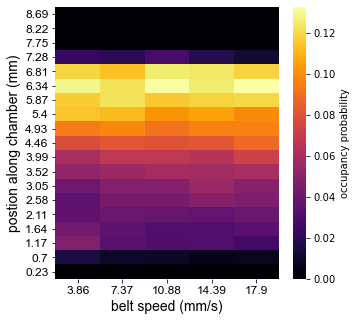

In [49]:
# plot the heatmap
fig = plt.figure(1, figsize = [5,5])
heatmap = sea.heatmap(prob_occupancy, cmap = 'inferno',cbar_kws={'label': 'occupancy probability'})
plt.xticks(np.arange(0,5)+0.5, driving_speeds, fontsize = 12, fontname = 'arial')
plt.yticks(np.arange(0,19)+0.5, bin_centers, fontsize = 12, fontname = 'arial', rotation = 0)
plt.ylabel('postion along chamber (mm)', fontsize = 14, fontname = 'arial')
plt.xlabel('belt speed (mm/s)', fontsize = 14, fontname = 'arial')
plt.gca().invert_yaxis()
plt.show()
fig.savefig(figure_dir + 'prob_occupancy.png', dpi = 300)
fig.savefig(figure_dir + 'prob_occupancy.svg', dpi = 300)

### Mean body length

In [32]:
print('Mean BL = ', np.mean(meta_matrix[:,4]))
print('STD BL =', np.std(meta_matrix[:,4]))

Mean BL =  2.0368129485102346
STD BL = 0.09525860939693455


### Quantification of burstiness

number of times the center of the chamber is crossed within the total amount of time for periods when the fly is upright

In [50]:
FS = 180
chamber_center = 8.929/2 # equavalent to a break beam
body_x = np.transpose(body_positions[3,:,:])
flies = np.unique(meta_matrix[:, 0]).astype(int).tolist()
driving_speeds = np.unique(meta_matrix[:, 2]).tolist()
fly_burst_frequency = np.zeros((len(flies), len(driving_speeds))) # flies, driving speeds
mean_burst_frequency = np.zeros(len(driving_speeds)) # flies, driving speeds
speed_cnt = -1
trial_adj = np.array([0, FS, FS*2, FS*3, FS*4])


for speed in driving_speeds:
    speed_cnt += 1
    speed_idxs = meta_matrix[:, 2] ==speed
    for fly in flies:
        fly_idxs = meta_matrix[:, 0] ==fly
        
        filt_idxs = np.logical_and.reduce((fly_idxs, speed_idxs))
        
        fly_body_x = body_x[filt_idxs ,:]
        fly_BL = meta_matrix[filt_idxs , -1]
        fly_beh_class = beh_class[filt_idxs , :]
        
        for j in range(fly_body_x.shape[0]): # iterate through trials and find the idxs of when the cross occured
            trial_x = fly_body_x[j, trial_adj[speed_cnt]:-1] * fly_BL[j] # mm
            trial_class = fly_beh_class[j, trial_adj[speed_cnt]:-1]
            
            # determine idxs of crossing events
            crossing_class = np.zeros(len(trial_x))
            crossing_class[trial_x>chamber_center] = 1
            diff_class = np.diff(crossing_class)
            diff_class[trial_class[1::]==8] = 0 # remove crossing events if they occured while the fly was upside down
            n_crossings = len(np.where(diff_class==1)[0])
            n_frames = len(np.where(trial_class[1::]!=8)[0])
            
            if j == 0:
                tot_crossing = n_crossings
                tot_time = n_frames/180
            else:
                tot_crossing += n_crossings
                tot_time += n_frames/180
            
        # save freq for each fly
        fly_burst_frequency[fly-1, speed_cnt] = tot_crossing/tot_time
        
        if fly == 1:
            mean_tot_crossing = tot_crossing
            mean_tot_time = tot_time
        else:
            mean_tot_crossing += tot_crossing
            mean_tot_time += tot_time
            
    # mean burst frequency
    mean_burst_frequency[speed_cnt] = mean_tot_crossing/mean_tot_time
        
                

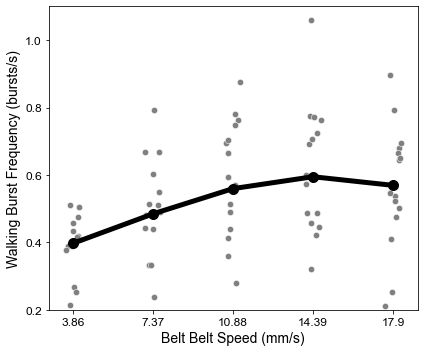

In [55]:
# plot burstiness - simple means
jitter_val = 0.1
w_adj = 0.25

fig = plt.figure(1, figsize =[6,5])

for j in range(len(driving_speeds)):
    curr_speed = driving_speeds[j]
    speed_fly_bursts =  fly_burst_frequency[:,j]
    x_jitter = (j+1)+ np.random.choice([-1,1],size=len(speed_fly_bursts))*np.random.uniform(low=0.0, high=jitter_val, size=len(speed_fly_bursts))
    sea.scatterplot(x=x_jitter, y=speed_fly_bursts, color = 'gray', s = 40, alpha = 1)
    
    # plot mean 
    # mean speed
plt.plot(np.arange(1,len(driving_speeds)+1), mean_burst_frequency, color ='black', marker='.', markersize = 20, linewidth = 5, alpha = 1, zorder = 25)
#     sea.lineplot(x=np.array([(j+1)-w_adj,(j+1)+w_adj]), y=np.array([mean_burst_frequency[j], mean_burst_frequency[j]]), color = 'black', linewidth = 4, alpha =1)
    
# axes
plt.ylabel('Walking Burst Frequency (bursts/s)', fontname ='Arial', fontsize = 14)
plt.xlabel('Belt Belt Speed (mm/s)', fontname = 'Arial', fontsize = 14)
plt.xticks(np.arange(1,6), np.array(driving_speeds).astype(str), fontsize = 12, rotation = 0, fontname="Arial")
plt.yticks(fontsize = 12, fontname = 'Arial')
plt.ylim([0.2,1.1])
plt.tight_layout()
plt.show()

fig.savefig(figure_dir + 'burst_freq.png', dpi = 300)
fig.savefig(figure_dir + 'burst_freq.pdf', dpi = 300)
fig.savefig(figure_dir + 'burst_freq.svg', dpi = 300)

### Quantification of Amount of Movement

In [120]:
flies = np.unique(meta_matrix[:, 0]).astype(int).tolist()
movement_amount = np.zeros(len(flies))
movement_time = np.zeros(len(flies))
for fly in flies:
    trial_idxs = np.where(meta_matrix[:, 0]==fly)[0]
    behs = beh_class[trial_idxs,:].flatten()
    vels = total_velocity[trial_idxs,:].flatten()
    x_mm = abx_mm[trial_idxs,:].flatten()
    
    # filter out upside down, error, and back of chamber classifications
    filt_idxs = ~np.logical_or.reduce((behs==8, behs==5)) # upside down and tracking error
    filt_vels = vels[filt_idxs]
    movement_amount[fly-1] = (len(filt_vels[filt_vels>=5])/len(filt_vels))
    movement_time[fly-1] = len(filt_vels[filt_vels>=5]) * (1/180)/ 60

In [121]:
movement_amount

array([0.50762022, 0.47226587, 0.47786356, 0.48861023, 0.52362697,
       0.489191  , 0.54375372, 0.519038  , 0.49017212, 0.50414161])

In [123]:
np.mean(movement_amount)

0.501628328896633

#### Plot the mean movement amount for each experimental setup

In [147]:
# load data
iav_results_dir = 'H:/.shortcut-targets-by-id/10pxdlRXtzFB-abwDGi0jOGOFFNm3pmFK/Tuthill Lab Shared/manuscripts/treadmill_2023/figures/raw/iav/raw/'
iav_save_dir = 'H:/.shortcut-targets-by-id/10pxdlRXtzFB-abwDGi0jOGOFFNm3pmFK/Tuthill Lab Shared/manuscripts/treadmill_2023/figures/raw/iav/'
ball_iav_data =  np.load(iav_results_dir + 'iav_kir2.1_ball_fraction_above_5mms.npy', allow_pickle=True)
flybowl_iav = pd.read_csv(iav_results_dir + 'iav_kir21_flybowl_walking_fraction.csv')['proportion walking'].values

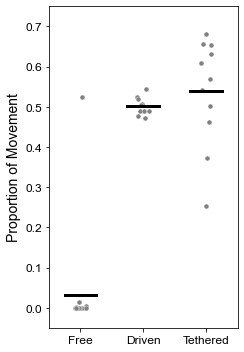

In [152]:
# plot the proportion of movement above 5 mm/s
jitter_val = 0.1
w_adj = 0.25
fb_x = 1+np.random.choice([-1,1],size=len(flybowl_iav))*np.random.uniform(low=0.0, high=jitter_val, size=len(flybowl_iav))
D_x = 2+np.random.choice([-1,1],size=len(movement_amount))*np.random.uniform(low=0.0, high=jitter_val, size=len(movement_amount))
T_x = 3+np.random.choice([-1,1],size=len(ball_iav_data))*np.random.uniform(low=0.0, high=jitter_val, size=len(ball_iav_data))
x_data = np.concatenate((fb_x, D_x, T_x))
y_data = np.concatenate((flybowl_iav, movement_amount, ball_iav_data))

fig = plt.figure(1, figsize =[3.5,5])
sea.scatterplot(x=x_data, y=y_data, color = 'gray', s = 25, alpha = 1)
sea.lineplot(x=np.array([1-w_adj,1+w_adj]), y=np.array([np.mean(flybowl_iav), np.mean(flybowl_iav)]), color = 'black', linewidth = 3, alpha =1)
sea.lineplot(x=np.array([2-w_adj,2+w_adj]), y=np.array([np.mean(movement_amount), np.mean(movement_amount)]), color = 'black', linewidth = 3, alpha =1)
sea.lineplot(x=np.array([3-w_adj,3+w_adj]), y=np.array([np.mean(ball_iav_data), np.mean(ball_iav_data)]), color = 'black', linewidth = 3, alpha =1)
plt.xlim([0.5,3.5])
plt.ylim([-0.05,0.75])
plt.xticks(np.arange(1,4), np.array(['Free', 'Driven', 'Tethered']), fontsize = 12, rotation = 0, fontname="Arial")
plt.yticks(fontsize = 12, fontname = 'Arial')
plt.ylabel('Proportion of Movement', fontname ='Arial', fontsize = 14)
plt.tight_layout()
plt.show()

fig.savefig(iav_save_dir + 'iav_movement.png', dpi = 250)
fig.savefig(iav_save_dir + 'iav_movement.pdf', dpi = 250)
fig.savefig(iav_save_dir + 'iav_movement.svg', dpi = 250)

### Linear treadmill stimulus

In [41]:
driving_speeds = np.array([7.37, 10.88, 14.39, 17.9])
stim_array = 3.86*np.ones(15)
time_array = np.arange(0,15)
for j in range(len(driving_speeds)):
    temp_array = driving_speeds[j] * np.ones(10)
    temp_array[0:j+2] = np.linspace(3.86, driving_speeds[j], j+2)
    stim_array = np.concatenate((stim_array, temp_array, 3.86*np.ones(5)))
    
    # time
    time_array = np.concatenate((time_array, np.arange(time_array[-1], time_array[-1]+10), np.arange(time_array[-1]+9, time_array[-1]+14)))


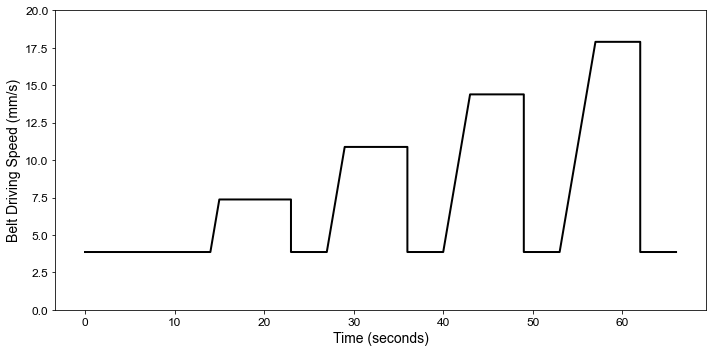

In [47]:
# plot stimulus
fig = plt.figure(1, figsize = [10,5])
plt.plot(time_array, stim_array, color ='black', linewidth = 2)
plt.xlabel('Time (seconds)', fontsize = 14, fontname = 'Arial')
plt.ylabel('Belt Driving Speed (mm/s)', fontsize = 14, fontname = 'Arial')
plt.xticks(fontsize = 12, fontname = 'Arial')
plt.yticks(fontsize = 12, fontname = 'Arial')
plt.ylim([0,20])
plt.tight_layout()
plt.show

fig.savefig(figure_dir + 'belt_stim.png', dpi = 200)
fig.savefig(figure_dir + 'belt_stim.pdf', dpi = 200)
fig.savefig(figure_dir + 'belt_stim.svg', dpi = 200)

### Speed-dependent body kinematics

In [52]:
driving_speeds = np.unique(meta_matrix[:, 2]).tolist()
flies = np.unique(meta_matrix[:, 0]).astype(int).tolist()#[0:10]
walking_speed_dists = []
walking_speed_stats = np.zeros((len(flies), len(driving_speeds))) 
mean_fly_speed = np.zeros(len(driving_speeds))
d_cnt = -1
for j in driving_speeds:
    d_cnt += 1
    for fly in flies:
        fly_idxs = meta_matrix[:, 0] == fly
        driving_speed_idxs = meta_matrix[:, 2] == j
        trial_idxs = np.logical_and.reduce((fly_idxs, driving_speed_idxs))
        
        # velocities and forward walking
        vels = parallel_vel[trial_idxs,:].flatten()
        beh_ids = beh_class[trial_idxs, :].flatten()
        
        fw_vels = vels[beh_ids==1]
        
        # filter our nans
        filt_fw_vels = fw_vels[~np.isnan(fw_vels)]
        
        # compute stats
        walking_speed_stats[fly-1, d_cnt] = np.nanmedian(filt_fw_vels)
        
        # store distribution data
        if fly ==1:
            vel_dist = filt_fw_vels
        else:
            vel_dist = np.concatenate((vel_dist, filt_fw_vels))
            
    walking_speed_dists.append(vel_dist)
    mean_fly_speed[d_cnt] = np.nanmean(vel_dist)
        

C:\Users\pratt\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


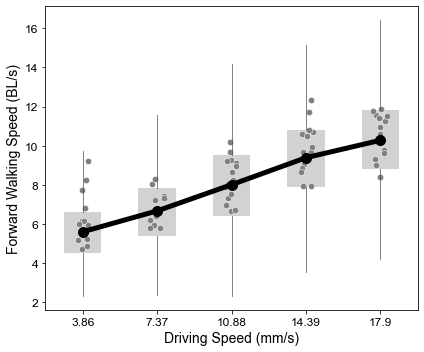

In [53]:
# plot driving speed by walking speed
jitter_val = 0.1
fig = plt.figure(1, figsize = [6,5])
# plot box plot
# sea.boxplot(data = walking_speed_dists, color = "black", width = 1, zorder = 1,\
# showcaps = True, boxprops = {'facecolor':'none', "zorder":1},\
# showfliers=False, whiskerprops = {'linewidth':2, "zorder":1},\
# saturation = 1)

# for j in range(walking_speed_stats.shape[0]):
# #     plt.plot(np.arange(0,len(driving_speeds)), walking_speed_stats[j,:], color ='dimgray', marker='.', markersize = 8, linewidth = 1, alpha = 0.8)
#     plt.plot(np.arange(0,len(driving_speeds)), walking_speed_stats[j,:], color ='gray', marker='.', markersize = 10, linewidth = 2.5, alpha = 1, zorder = 20)

for j in range(len(driving_speeds)):
    curr_speed = driving_speeds[j]
    fly_speed =  walking_speed_stats[:,j]
    x_jitter = (j)+ np.random.choice([-1,1],size=len(fly_speed))*np.random.uniform(low=0.0, high=jitter_val, size=len(fly_speed))
    sea.scatterplot(x=x_jitter, y=fly_speed, color = 'gray', s = 40, alpha = 1, zorder = 10)
    
    
# mean speed
plt.plot(np.arange(0,len(driving_speeds)), mean_fly_speed, color ='black', marker='.', markersize = 20, linewidth = 5, alpha = 1, zorder = 25)



# background boxplot
sea.boxplot(data = walking_speed_dists,
               color = "gray",width = 0.5, showcaps = False, boxprops = {'edgecolor':'none','facecolor':'silver', "zorder":1, "alpha":0.7},
               showfliers=False, whiskerprops = {'linewidth':1, "zorder":10, "alpha":0.7}, medianprops=dict(color="none"))
    
# axis properties
plt.yticks(fontsize = 12, fontname = 'Arial')
plt.xticks(np.arange(len(driving_speeds)), np.array(driving_speeds).astype(str), fontsize = 12, rotation = 0, fontname="Arial")
plt.xlabel('Driving Speed (mm/s)', fontsize = 14, fontname = 'Arial')
plt.ylabel('Forward Walking Speed (BL/s)', fontsize = 14, fontname = 'Arial')

plt.tight_layout()
plt.show()

fig.savefig(figure_dir + 'driving_walking_speed_v2'+'.png', dpi = 200)
fig.savefig(figure_dir + 'driving_walking_speed_v2'+'.pdf', dpi = 200)
fig.savefig(figure_dir + 'driving_walking_speed_v2'+'.svg', dpi = 200)

#### 1D body kinematics, posture, and interlimb coordination 

In [59]:
def one_dimensional_metrics(metric, w_vel, meta_matrix, beh_class):
    dist_cnt = 0
    for fly in np.unique(meta_matrix[:, 0]).astype(int).tolist(): #[0:10]: #[0:10] - select the data of the first 10 flies
        trial_idxs = np.where(meta_matrix[:, 0] == fly)[0]

        # extract data
        vel_data = w_vel[trial_idxs,:].flatten()
        metric_data = metric[trial_idxs,:].flatten() # doesn't need to be transposed

        # behavior classifier
        beh_ids = beh_class[trial_idxs, :].flatten()

        # filter for forward walking behavior == 1
        fw_vel_data = vel_data[beh_ids==1]
        fw_metric_data = metric_data[beh_ids==1]

        # filter concatenated data to remove Nans
        filter_vels = fw_vel_data[~np.isnan(fw_metric_data)]
        filter_data  = fw_metric_data[~np.isnan(fw_metric_data)]

        # filter out -1 values
        filter_vels = filter_vels[~(filter_data ==-1)]
        filter_data = filter_data[~(filter_data ==-1)]
        
        # filter out zero values
        filter_vels = filter_vels[~(filter_data ==0)]
        filter_data = filter_data[~(filter_data ==0)]

        # if there are a sufficient number of steps then store data as a distribution
        if dist_cnt == 0:
            data_dist = filter_data
            vel_dist = filter_vels
            fly_dist = fly*np.ones(len(filter_data))
            dist_cnt = 1
        else:
            data_dist = np.concatenate((data_dist, filter_data))
            vel_dist = np.concatenate((vel_dist, filter_vels))
            fly_dist = np.concatenate((fly_dist, fly*np.ones(len(filter_data))))

    # stack data
    all_data = np.vstack((fly_dist, vel_dist, data_dist))
    
    return all_data

In [60]:
# get distribution data
w_vel = parallel_vel

# ALL 1D kinemtic, coordination, and posture parameters
body_height_dist = one_dimensional_metrics(-body_height_walking, w_vel, meta_matrix, beh_class)
nlegs_stance_dist = one_dimensional_metrics(nlegs_stance_walking, w_vel, meta_matrix, beh_class)

In [61]:
# Plots with marginal distrbutions added
def plot_1D_metrics_marginal_dists(plot_metric, ylabel_name, fig_name, p_coeff, plot_scatter):
    # plot 1D metrics
    g = sea.JointGrid()

    # scatter
    if plot_scatter:
        sea.scatterplot(x=plot_metric[1,:], y=plot_metric[2,:], color = 'darkgray', s = 5, alpha = 1, ax=g.ax_joint)
#         sea.scatterplot(x=plot_metric[1,:]+ np.random.choice([-1,1],size=len(plot_metric[1,:]))*np.random.uniform(low=0.0, high=0.15, size=len(plot_metric[1,:])), y=plot_metric[2,:], color = 'darkgray', s = 5, alpha = 1, ax=g.ax_joint)

    # plot for each fly 
    unique_flies = np.unique(plot_metric[0,:]).tolist()#[0:10]
    for fly in unique_flies:
        fly_idxs = np.where(plot_metric[0,:]==fly)[0] 
        vel_fit = np.linspace(np.min(plot_metric[1,fly_idxs]), np.max(plot_metric[1,fly_idxs]), 100)
        p = np.polyfit(plot_metric[1,fly_idxs], plot_metric[2,fly_idxs], p_coeff) # estimated coefficents...least squares polynomial fit
        y_fit = np.polyval(p, vel_fit)
        sea.lineplot(x=vel_fit, y=y_fit, color = 'dimgray', linewidth = 2, alpha =1, ax=g.ax_joint)

    # global fits
    n_frames = len(plot_metric[1,:])
    vel_fit = np.linspace(np.min(plot_metric[1,:]), np.max(plot_metric[1,:]), 100)
    p = np.polyfit(plot_metric[1,:], plot_metric[2,:], p_coeff) # estimated coefficents...least squares polynomial fit
    y_fit = np.polyval(p, vel_fit)
    r2_val = np.around(r2_score(plot_metric[2,:], np.polyval(p, plot_metric[1,:])),2)
    sea.lineplot(x=vel_fit, y=y_fit, color = 'black', linewidth = 4, alpha =1, ax=g.ax_joint)

    # kde propability - speed and metric
    sea.kdeplot(x=plot_metric[1,:], linewidth=2, color = 'black', ax=g.ax_marg_x)
    sea.kdeplot(y=plot_metric[2,:], linewidth=2, color = 'black', ax=g.ax_marg_y)


    # legend
    #     plt.text(0.55, 0.9, '$R^{2}$ =' + str(r2_val), horizontalalignment='center',verticalalignment='center',transform = ax.transAxes, fontsize = 14, fontname ='Arial')
    # g.ax_joint.title('$R^{2}$ =' + str(r2_val), fontsize = 16)
    # g.ax_joint.set_yticks(fontsize=12, fontname ='Arial')
    # g.ax_joint.xticks(fontsize=12, fontname ='Arial')
#     g.ax_joint.set_xlabel('Average Bout Speed (BL/s)', fontsize=14, fontname ='Arial')
    g.ax_joint.set_xlabel('Forward Walking Speed (BL/s)', fontsize=14, fontname ='Arial')
#     g.ax_joint.set_xlabel('Driving Speed (mm/s)', fontsize=14, fontname ='Arial')
    g.ax_joint.set_ylabel(ylabel_name, fontsize=14, fontname ='Arial')
    g.ax_joint.tick_params(axis='both', labelsize=14)
    g.ax_joint.set_title('$R^{2}$ =' + str(r2_val), fontsize = 16)

    g.ax_joint.set_xlim([2,20])
    g.ax_joint.set_ylim([0.35,0.7])
    plt.tight_layout()
    plt.show()

    g.savefig(figure_dir + fig_name+'.png', dpi = 200)
    g.savefig(figure_dir + fig_name+'.pdf', dpi = 200)
    g.savefig(figure_dir + fig_name+'.svg', dpi = 200)

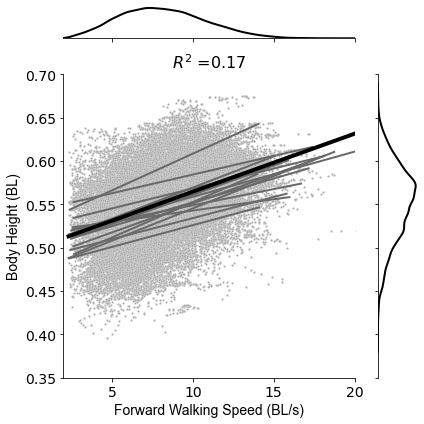

In [62]:
plot_metric = body_height_dist
ylabel_name = 'Body Height (BL)'
fig_name = 'body_height'
p_coeff = 1
plot_scatter = True
plot_1D_metrics_marginal_dists(plot_metric, ylabel_name, fig_name, p_coeff, plot_scatter)

#### Probability of number of legs in stance

In [50]:
speed_dist = parallel_vel.flatten()
nlegs_dist = nlegs_stance_walking.flatten()

beh_ids = beh_class.flatten()

# isolate forward walking
fw_nlegs = nlegs_dist[beh_ids==1]
fw_vel = speed_dist[beh_ids==1]

# filter nlegs - remove nans
fw_vel = fw_vel[~np.isnan(fw_nlegs)]
fw_nlegs = fw_nlegs[~np.isnan(fw_nlegs)]


# edges of distributions
vel_bins = 6
# vel_grid = np.linspace(np.min(fw_vel), np.max(fw_vel), vel_bins)
vel_grid = np.linspace(2, 18, vel_bins)
vel_center = np.around(vel_grid[1::] - (vel_grid[1]-vel_grid[0]),2)
nleg_cat = np.unique(fw_nlegs)

# compute probability distribution for each of the nleg categories
nleg_prob = np.zeros((len(nleg_cat), len(vel_center)))
for j in range(len(nleg_cat)):
    leg_idxs = np.where(fw_nlegs == nleg_cat[j])[0]
    for i in range(len(vel_center)):
        nleg_vels = fw_vel[leg_idxs]
        nleg_prob[j,i] = len(np.where(np.logical_and(nleg_vels>=vel_grid[i], nleg_vels<=vel_grid[i+1])==True)[0])
        
nleg_prob = nleg_prob/np.sum(nleg_prob, axis = 0)


# plot the probability of a certain number of legs in stance
fig = plt.figure(1, figsize = [6,5])
# plt.style.use('ggplot')
plt_colors = ['gold', 'violet', 'red', 'dimgray', 'blue', 'mediumseagreen', 'purple']
for j in range(nleg_prob.shape[0]):
    plt.plot(vel_center, nleg_prob[j,:], linewidth =2, color = plt_colors[j])

# axis properties
plt.xticks(fontsize = 12, fontname = 'Arial')
plt.yticks(fontsize = 12, fontname = 'Arial')
plt.xlabel('Forward Walking Speed (BL/s)', fontsize = 14, fontname = 'Arial')
plt.ylabel('Probability', fontsize = 14, fontname = 'Arial')
plt.xlim([2, 15])
plt.ylim([0, 0.75])

plt.legend(nleg_cat.astype(str), fontsize =12)
plt.grid(False)
plt.tight_layout()
plt.show()

fig.savefig(figure_dir + 'nleg_stance_prob'+'.png', dpi = 200)
fig.savefig(figure_dir + 'nleg_stance_prob'+'.pdf', dpi = 200)
fig.savefig(figure_dir + 'nleg_stance_prob'+'.svg', dpi = 200)

### Speed-dependent intralimb kinematics

- scatter plots with fits - combine leg pairs on the same plot

- only focus on forward walking bouts

In [3]:
def intralimb_kinematic_distrbutions(metric, w_vel, n_step_threshold, stance_filter, stance_threshold):

    # iterate through legs 
    leg_dists = [] # front, middle, hind
    for leg in range(3):
        dist_cnt = 0
        for fly in np.unique(meta_matrix[:, 0]).astype(int).tolist():#:[0:10]:
            trial_idxs = np.where(meta_matrix[:, 0] == fly)[0]

            # extract data
            vel_data = w_vel[trial_idxs,:].flatten()
            leg1_data = metric[leg, :, trial_idxs].flatten() # doesn't need to be transposed
            leg2_data = metric[leg+3, :, trial_idxs].flatten()
            
            # filter metric
            stance_filt_1 = stance_filter[leg, :, trial_idxs].flatten()
            stance_filt_2 = stance_filter[leg+3, :, trial_idxs].flatten()

            # behavior classifier
            beh_ids = beh_class[trial_idxs, :].flatten()

            # filter for forward walking behavior == 1
            fw_vel_data = vel_data[beh_ids==1]
            fw_leg1_data = leg1_data[beh_ids==1]
            fw_leg2_data = leg2_data[beh_ids==1]
                
            # fw filter metric
            fw_stance_filt_1 = stance_filt_1[beh_ids==1]
            fw_stance_filt_2 = stance_filt_2[beh_ids==1]

            # concatenate data
            cat_vel = np.concatenate((fw_vel_data, fw_vel_data))
            cat_data = np.concatenate((fw_leg1_data, fw_leg2_data))
            cat_filt_metric = np.concatenate((fw_stance_filt_1, fw_stance_filt_2))

            # filter concatenated data to remove Nans
            filter_vels = cat_vel[~np.isnan(cat_data)]
            filter_metric = cat_filt_metric[~np.isnan(cat_data)]
            filter_data  = cat_data[~np.isnan(cat_data)]
            
            # filter out -1 values
            filter_vels = filter_vels[~(filter_data ==-1)]
            filter_metric = filter_metric[~(filter_data ==-1)]
            filter_data = filter_data[~(filter_data ==-1)]
            
            # filter out velocity and data if it doesn't satisfy filter metric
            filter_vels = filter_vels[filter_metric>stance_threshold]
            filter_data = filter_data[filter_metric>stance_threshold]

            # if there are a sufficient number of steps then store data as a distribution
            if len(filter_data) >= n_step_threshold:
                if dist_cnt == 0:
                    data_dist = filter_data
                    vel_dist = filter_vels
                    fly_dist = fly*np.ones(len(filter_data))
                    dist_cnt = 1
                else:
                    data_dist = np.concatenate((data_dist, filter_data))
                    vel_dist = np.concatenate((vel_dist, filter_vels))
                    fly_dist = np.concatenate((fly_dist, fly*np.ones(len(filter_data))))

        # stack data
        all_data = np.vstack((fly_dist, vel_dist, data_dist))
        leg_dists.append(all_data)
    
    return leg_dists   

In [4]:
# compute distributions for intralimb kinematics
# filtering parameters
n_step_threshold = 15 # need at least 15 steps from a fly
stance_threshold = 0.02

step_freq_distributions = intralimb_kinematic_distrbutions(step_freq, parallel_vel, n_step_threshold, stance_duration, stance_threshold)
stance_duration_distributions = intralimb_kinematic_distrbutions(stance_duration, parallel_vel, n_step_threshold, stance_duration, stance_threshold)
swing_duration_distributions = intralimb_kinematic_distrbutions(swing_duration, parallel_vel, n_step_threshold, stance_duration, stance_threshold)
step_distance_distributions = intralimb_kinematic_distrbutions(step_distance, parallel_vel, n_step_threshold, stance_duration, stance_threshold)
step_length_distributions = intralimb_kinematic_distrbutions(step_length, parallel_vel, n_step_threshold, stance_duration, stance_threshold)

#### Data for stats

In [6]:
cat_vels = np.concatenate((step_freq_distributions[0][1,:], step_freq_distributions[1][1,:], step_freq_distributions[2][1,:]))
cat_step_freq  = np.concatenate((step_freq_distributions[0][2,:], step_freq_distributions[1][2,:], step_freq_distributions[2][2,:]))
cat_stance_duration  = np.concatenate((stance_duration_distributions[0][2,:], stance_duration_distributions[1][2,:], stance_duration_distributions[2][2,:]))
cat_swing_duration  = np.concatenate((swing_duration_distributions[0][2,:], swing_duration_distributions[1][2,:], swing_duration_distributions[2][2,:]))
cat_step_length  = np.concatenate((step_length_distributions[0][2,:],step_length_distributions[1][2,:], step_length_distributions[2][2,:]))
cat_length_vel  = np.concatenate((step_length_distributions[0][1,:],step_length_distributions[1][1,:], step_length_distributions[2][1,:]))

In [7]:
# isolate kinematics during speed range
lower_vel = 7.106482228957478 # based on freely walking data
upper_vel = 11.237349005793016
step_freq_stats = cat_step_freq[np.logical_and(cat_vels>lower_vel, cat_vels<upper_vel)]
stance_duration_stats = cat_stance_duration[np.logical_and(cat_vels>lower_vel, cat_vels<upper_vel)]
swing_duraiton_stats = cat_swing_duration[np.logical_and(cat_vels>lower_vel, cat_vels<upper_vel)]
step_length_stats = cat_step_length[np.logical_and(cat_length_vel>lower_vel, cat_length_vel<upper_vel)]

In [12]:
savedir = 'H:/.shortcut-targets-by-id/10pxdlRXtzFB-abwDGi0jOGOFFNm3pmFK/Tuthill Lab Shared/manuscripts/treadmill_2023/figures/raw/wt berlin/data for stats/'
np.save(savedir+'step_freq_stats.npy', step_freq_stats)
np.save(savedir+'stance_duration_stats.npy', stance_duration_stats)
np.save(savedir+'swing_duration_stats.npy', swing_duraiton_stats)
np.save(savedir+'step_length_stats.npy', step_length_stats)

#### save data

In [7]:
def save_intralimb_kinematic_data(metric, metric_name, figure_dir):
    cnt = -3
    for leg in range(3):
        cnt += 3
        slow_data = metric[leg][2,:][metric[leg][1,:]<6]
        int_data = metric[leg][2,:][np.logical_and(metric[leg][1,:]>=6, metric[leg][1,:]<=10)]
        fast_data = metric[leg][2,:][metric[leg][1,:]>10]

        if leg == 0:
            cat_data = np.concatenate((slow_data, int_data, fast_data))
            cat_id = np.concatenate((cnt*np.ones(len(slow_data)), (cnt+1)*np.ones(len(int_data)), (cnt+2)*np.ones(len(fast_data))))
        else:
            cat_data = np.concatenate((cat_data, slow_data, int_data, fast_data))
            cat_id = np.concatenate((cat_id, cnt*np.ones(len(slow_data)), (cnt+1)*np.ones(len(int_data)), (cnt+2)*np.ones(len(fast_data))))

    # combine data and id arrays
    cat_array = np.vstack((cat_data, cat_id))
    np.save(figure_dir+'/data/'+metric_name+'.npy', cat_array)

In [8]:
figure_dir

'H:/.shortcut-targets-by-id/10pxdlRXtzFB-abwDGi0jOGOFFNm3pmFK/Tuthill Lab Shared/manuscripts/treadmill_2023/figures/raw/wt berlin/linear_treadmill/'

In [9]:
# save intralimb kinematic parameters
save_intralimb_kinematic_data(step_freq_distributions, 'upsampled_step_freq', figure_dir)
save_intralimb_kinematic_data(stance_duration_distributions, 'upsampled_stance_duration', figure_dir)
save_intralimb_kinematic_data(swing_duration_distributions, 'upsampled_swing_duration', figure_dir)

# save_intralimb_kinematic_data(step_freq_distributions, 'step_freq', figure_dir)
# save_intralimb_kinematic_data(stance_duration_distributions, 'stance_duration', figure_dir)
# save_intralimb_kinematic_data(swing_duration_distributions, 'swing_duration', figure_dir)
# save_intralimb_kinematic_data(step_distance_distributions, 'step_distance', figure_dir)
save_intralimb_kinematic_data(step_length_distributions, 'step_length', figure_dir)

#### Plot Intralimb kinematics

In [66]:
def plot_intralimb_kinematics_marginal_distribution(plot_metric, ylabel_name, fig_name, p_coeff, plot_scatter, ylim, add_jitter, graded_jitter, size_gradient, sizes, add_offset, offset_val):
    # plot parameters
    leg_colors = ['tab:blue', 'tab:orange', 'tab:green']

    # plot 1D metrics
    g = sea.JointGrid()

    # scatter
    if plot_scatter:
        for leg in range(3):
            if add_jitter:
                jitter_y = plot_metric[leg][2,:] + np.random.choice([-1,1],size=len(plot_metric[leg][2,:]))*np.random.uniform(low=0.0, high=graded_jitter[leg], size = len(plot_metric[leg][2,:]))
                sea.scatterplot(x=plot_metric[leg][1,:], y= jitter_y, color = leg_colors[leg], s = 5, alpha = 0.25, ax=g.ax_joint) # alpha was 0.25
            elif size_gradient:
                sea.scatterplot(x=plot_metric[leg][1,:], y= plot_metric[leg][2,:], color = leg_colors[leg], s = sizes[leg], alpha = 1, ax=g.ax_joint) # alpha was 0.25
            elif add_offset:
                offset_y = np.array([1,-1,0])[leg] * offset_val 
                sea.scatterplot(x=plot_metric[leg][1,:], y= plot_metric[leg][2,:] + offset_y, color = leg_colors[leg], s = 5, alpha = 0.25, ax=g.ax_joint) # alpha was 0.25
            else:
                sea.scatterplot(x=plot_metric[leg][1,:], y=plot_metric[leg][2,:], color = leg_colors[leg], s = 5, alpha = 0.25, ax=g.ax_joint)

    # average speed bins instead of fitting
    bin_size = 2
    speed_start = 2 # BL/s
    speed_end = 14 # 15.5 # BL/s
    bin_edges = np.arange(speed_start, speed_end, bin_size)
    ave_fits = np.zeros((3, len(bin_edges), 2)) # leg pairs, number of bins, mean + 95% confidence
    for j in range(3):
        for i in range(len(bin_edges)):
            bin_data = plot_metric[j][2, np.logical_and(plot_metric[j][1,:] >= bin_edges[i], plot_metric[j][1,:] < bin_edges[i] + bin_size)]
            ave_fits[j,i,0] = np.mean(bin_data) # mean
            ave_fits[j,i,1] = (1.96 * np.std(bin_data))/np.sqrt(len(bin_data)) # 95% confidence
        
        # plot the mean line
        sea.lineplot(x=bin_edges+(bin_size/2), y=ave_fits[j,:,0], color = leg_colors[j], linewidth = 2.5, alpha =1, ax=g.ax_joint)


    # kde propability - speed and metric
    for leg in range(3):
        sea.kdeplot(x=plot_metric[leg][1,:], linewidth=2, color = leg_colors[leg], ax=g.ax_marg_x, alpha = 0.25, bw_adjust = 2.5)
        sea.kdeplot(y=plot_metric[leg][2,:], linewidth=2, color = leg_colors[leg], ax=g.ax_marg_y, alpha = 0.25, bw_adjust = 2.5)


    # legend and plotting parameters
     # global fits
    n_steps = np.zeros(3)
    for leg in range(3):
        n_steps[leg] = len(plot_metric[leg][1,:])
        
    legend_text = ['Front Legs (steps = '+str(int(n_steps[0]))+ ')', 'Middle Legs (steps = '+str(int(n_steps[1]))+')', 'Hind Legs (steps = '+str(int(n_steps[2]))+ ')']
    g.ax_joint.legend(legend_text, fontsize = 12, bbox_to_anchor=(1.0, 1.5))
    g.ax_joint.set_xlabel('Forward Walking Speed (BL/s)', fontsize=14, fontname ='Arial')
    g.ax_joint.set_ylabel(ylabel_name, fontsize=14, fontname ='Arial')
    g.ax_joint.tick_params(axis='both', labelsize=14)

    g.ax_joint.set_xlim([0,20])
    g.ax_joint.set_ylim([ylim[0],ylim[1]])
    plt.tight_layout()
    plt.show()

    g.savefig(figure_dir + fig_name+'_offset.png', dpi = 200)
    g.savefig(figure_dir + fig_name+'_offset.pdf', dpi = 200)
    g.savefig(figure_dir + fig_name+'_offset.svg', dpi = 200)

C:\Users\pratt\AppData\Local\Temp\ipykernel_7696\872479902.py:58: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


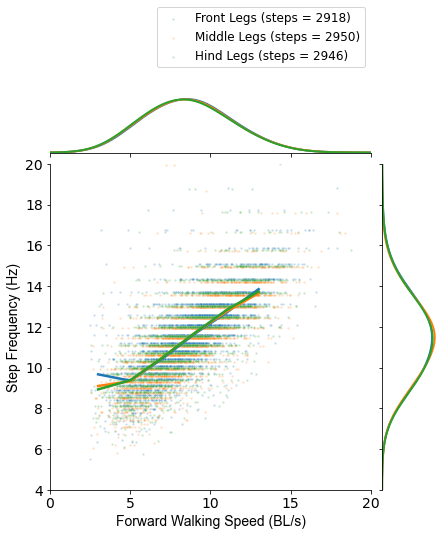

In [67]:
# plot_metric = step_freq_distributions
plot_metric = step_freq_distributions
ylabel_name = 'Step Frequency (Hz)'
fig_name = 'Step_freq'
p_coeff = 1
plot_scatter = True

# jitter to points
add_jitter = False
jitter_val = [0.25, 0.1, 0]

# size gradient of scatter
size_gradient = False
sizes = [18,6,3]

# add offset
add_offset = True 
offset_val = 0.075

ylim = [4,20]
plot_intralimb_kinematics_marginal_distribution(plot_metric, ylabel_name, fig_name, p_coeff, plot_scatter, ylim, add_jitter, jitter_val, size_gradient, sizes, add_offset, offset_val)

C:\Users\pratt\AppData\Local\Temp\ipykernel_7696\872479902.py:58: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


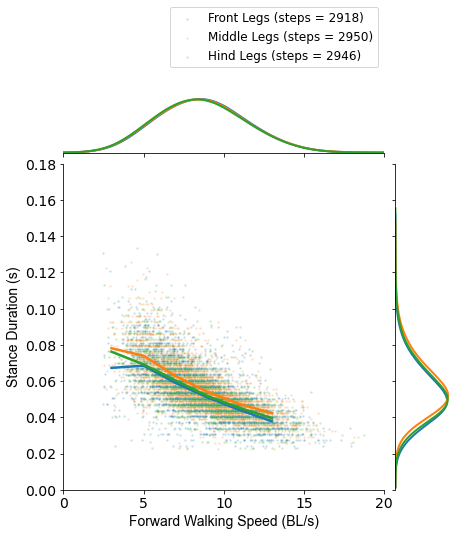

In [68]:
# plot_metric = step_freq_distributions
plot_metric = stance_duration_distributions
ylabel_name = 'Stance Duration (s)'
fig_name = 'Stance_duration'
p_coeff = 2
plot_scatter = True
ylim = [0, 0.18]

# jitter to points
add_jitter = False
jitter_val = [0.25, 0.1, 0]

# size gradient of scatter
size_gradient = False
sizes = [18,6,3]

# add offset
add_offset = True 
offset_val = 0.00085

plot_intralimb_kinematics_marginal_distribution(plot_metric, ylabel_name, fig_name, p_coeff, plot_scatter, ylim, add_jitter, jitter_val, size_gradient, sizes, add_offset, offset_val)

C:\Users\pratt\AppData\Local\Temp\ipykernel_7696\872479902.py:58: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


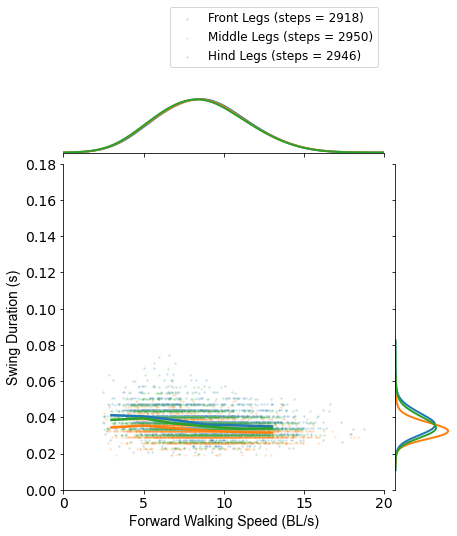

In [70]:
# plot_metric = step_freq_distributions
plot_metric = swing_duration_distributions
ylabel_name = 'Swing Duration (s)'
fig_name = 'Swing_duration'
p_coeff = 1
plot_scatter = True
# ylim = [0.015, 0.075]
ylim = [0, 0.18]

# jitter to points
add_jitter = False
jitter_val = [0.25, 0.1, 0]

# size gradient of scatter
size_gradient = False
sizes = [18,6,3]

# add offset
add_offset = True 
offset_val = 0.00085#0.0004

plot_intralimb_kinematics_marginal_distribution(plot_metric, ylabel_name, fig_name, p_coeff, plot_scatter, ylim, add_jitter, jitter_val, size_gradient, sizes, add_offset, offset_val)

C:\Users\pratt\AppData\Local\Temp\ipykernel_21828\872479902.py:58: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


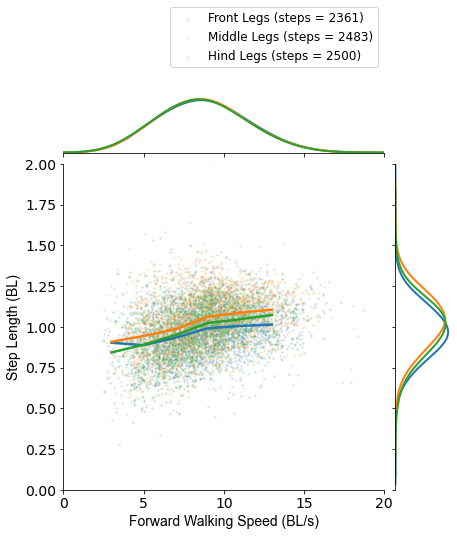

In [12]:
plot_metric = step_length_distributions
ylabel_name = 'Step Length (BL)'
fig_name = 'step_length'
p_coeff = 1
plot_scatter = True
ylim = [0.0, 2.0]

# jitter to points
add_jitter = False
jitter_val = [0.25, 0.1, 0]

# size gradient of scatter
size_gradient = False
sizes = [18,6,3]

# add offset
add_offset = False
offset_val = 0.0005

plot_intralimb_kinematics_marginal_distribution(plot_metric, ylabel_name, fig_name, p_coeff, plot_scatter, ylim, add_jitter, jitter_val, size_gradient, sizes, add_offset, offset_val)

C:\Users\pratt\AppData\Local\Temp\ipykernel_28112\2056003805.py:65: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


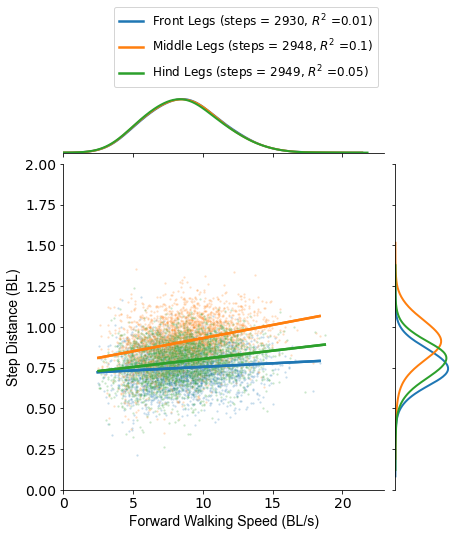


KeyboardInterrupt



In [15]:
plot_metric = step_distance_distributions
ylabel_name = 'Step Distance (BL)'
fig_name = 'step_distance'
p_coeff = 1
plot_scatter = True
ylim = [0.0, 2.0]

# jitter to points
add_jitter = False
jitter_val = [0.25, 0.1, 0]

# size gradient of scatter
size_gradient = False
sizes = [18,6,3]

# add offset
add_offset = False
offset_val = 0.0005

plot_intralimb_kinematics_marginal_distribution(plot_metric, ylabel_name, fig_name, p_coeff, plot_scatter, ylim, add_jitter, jitter_val, size_gradient, sizes, add_offset, offset_val)

### Plot step kinematics across setups

In [5]:
# load data
datadir = 'H:/.shortcut-targets-by-id/10pxdlRXtzFB-abwDGi0jOGOFFNm3pmFK/Tuthill Lab Shared/manuscripts/treadmill_2023/figures/raw/wt berlin/data for stats/'
fb_step_freq = np.load(datadir+'upsampled_step_freq_FB_v4.npy')#[0,:]
fb_stance_duration = np.load(datadir+'upsampled_stance_duration_FB_v4.npy')#[0,:]
fb_swing_duration = np.load(datadir+'upsampled_swing_duration_FB_v4.npy')#[0,:]
fb_step_length = np.load(datadir+'step_length_FB_v4.npy')#[0,:]
tb_data = np.load(datadir+'kin_params_ball_2024-01-23.npy')
lb_step_freq = np.concatenate((step_freq_distributions[0][2,:], step_freq_distributions[1][2,:], step_freq_distributions[2][2,:]))
lb_stance_duration = np.concatenate((stance_duration_distributions[0][2,:], stance_duration_distributions[1][2,:], stance_duration_distributions[2][2,:]))
lb_swing_duration= np.concatenate((swing_duration_distributions[0][2,:], swing_duration_distributions[1][2,:], swing_duration_distributions[2][2,:]))
lb_step_length= np.concatenate((step_length_distributions[0][2,:], step_length_distributions[1][2,:], step_length_distributions[2][2,:]))

In [6]:
# combine data
cat_step_freq = [lb_step_freq, fb_step_freq[0,:], tb_data[1,:]]
cat_stance_duration = [lb_stance_duration, fb_stance_duration[0,:], tb_data[2,:]]
cat_swing_duraiton = [lb_swing_duration, fb_swing_duration[0,:], tb_data[3,:]]
cat_step_length = [lb_step_length, fb_step_length[0,:], tb_data[4,:]]
id_1 = np.concatenate((0*np.ones(len(lb_step_freq)), np.ones(len(fb_step_freq[0,:])), 2*np.ones(len(tb_data[1,:]))))
id_2 = np.concatenate((0*np.ones(len(lb_step_length)), np.ones(len(fb_step_length[0,:])), 2*np.ones(len(tb_data[4,:]))))

#### Run stats on step kinematics across setups

##### statistical comparisons between free and treadmill, and free and tethered

In [8]:
from scipy import stats
def bootstrap_stats(n_bootstraps, pval_thresh, bon_correction, pop1, pop2, plotting, comparasion):
    print(comparasion)
    n_pop1 = len(pop1)
    n_pop2 = len(pop2)
    mean_pop_diff = np.mean(pop2) - np.mean(pop1) # BL
    pooled_pop = np.concatenate((pop1, pop2))

    # bootstraping 
    mean_stat_diff = np.zeros(n_bootstraps)
    for j in range(n_bootstraps):
        resample_pop1 = np.random.permutation(pooled_pop)[0:n_pop1] # randomly permute from a uniform distribution
        resample_pop2 = np.random.permutation(pooled_pop)[n_pop1::]
        mean_stat_diff[j] = np.mean(resample_pop2) - np.mean(resample_pop1)

    if plotting:
        plt.figure(1, figsize =[5,5])
        hist, bin_edges = np.histogram(mean_stat_diff, bins=30, density=True)
        plt.hist(mean_stat_diff, bins = 30, color='k', density = True)
        plt.plot(np.array([mean_pop_diff, mean_pop_diff]), np.array([0,max(hist)]), color ='r')

    # compute p-value
    if mean_pop_diff> 0:
        n_sig_samples = len(np.where(mean_stat_diff>=mean_pop_diff)[0])
    else:
        n_sig_samples = len(np.where(mean_stat_diff<=mean_pop_diff)[0])
    pvalue = n_sig_samples/n_bootstraps
    if pvalue == 0: # correct for the number of bootstraps
        pvalue = 1/n_bootstraps
    print('p value = ', pvalue)

    # significance threshold with bonferroni correction
    if pvalue <= (pval_thresh/bon_correction):
        print('Statistically Significant')
    else:
        print('Not Statistically Significant')

In [29]:
pop1_vals, pop1_counts = np.unique(metric[j], return_counts=True)
pop2_vals, pop2_counts = np.unique(metric[1], return_counts=True)
freq_pop1 = pop1_counts/(np.sum(pop1_counts)) *100
freq_pop2 = pop2_counts/(np.sum(pop1_counts)) *100
freq_pop1_aligned = np.zeros(len(pop2_vals))
for j in range(len(pop2_vals)):
    if pop2_vals[j] in pop1_vals:
        freq_pop1_aligned[j] = freq_pop1[pop1_vals==pop2_vals[j]]

In [46]:
# define bootstrapping parameters
comparison_names = ['Treadmill_Free', 'Tethered_Free']
n_bootstraps = 5000
pval_thresh = 0.05
bon_correction = 18 # 6 legs and 3 setups
print('p critical = ', pval_thresh/bon_correction)
plotting = False
metric = cat_step_freq
metric_name = 'Step Frequency'
cnt = -1
for j in [0,2]:
    cnt+=1
    comparasion = metric_name +' '+comparison_names[cnt]
    pop1 = metric[j]
    pop2 = metric[1]
    bootstrap_stats(n_bootstraps, pval_thresh, bon_correction, pop1, pop2, plotting, comparasion)
    print('Kruskal Wallis p = ', stats.kruskal(pop1, pop2)[1])
    print('t-test p = ', stats.ttest_ind(pop1, pop2, equal_var = False)[1]) # identical averages
    
    # Chi-Squared
    pop1_vals, pop1_counts = np.unique(pop1, return_counts=True)
    pop2_vals, pop2_counts = np.unique(pop2, return_counts=True)
    freq_pop1 = pop1_counts/(np.sum(pop1_counts)) *100
    freq_pop2 = pop2_counts/(np.sum(pop2_counts)) *100
    freq_pop1_aligned = np.zeros(len(pop2_vals))
    for j in range(len(pop2_vals)):
        if pop2_vals[j] in pop1_vals:
            freq_pop1_aligned[j] = pop1_counts[pop1_vals==pop2_vals[j]]
    freq_pop1_aligned = (freq_pop1_aligned/np.sum(freq_pop1_aligned))*100
    print('Chi-squared p = ', stats.chisquare(f_obs=freq_pop1_aligned, f_exp=freq_pop2)[1])      
    # print(stats.kstest(pop1, pop2))
    print('-----------------------------------------------------------------------')

p critical =  0.002777777777777778
Step Frequency Treadmill_Free
p value =  0.0002
Statistically Significant
Kruskal Wallis p =  9.193950904194234e-156
t-test p =  2.822826488643665e-148
Chi-squared p =  0.801215315471364
-----------------------------------------------------------------------
Step Frequency Tethered_Free
p value =  0.0002
Statistically Significant
Kruskal Wallis p =  0.0
t-test p =  0.0
Chi-squared p =  2.351698962470033e-15
-----------------------------------------------------------------------


In [47]:
# define bootstrapping parameters
comparison_names = ['Treadmill_Free', 'Tethered_Free']
n_bootstraps = 5000
pval_thresh = 0.05
bon_correction = 18 # 6 legs and 3 setups
print('p critical = ', pval_thresh/bon_correction)
plotting = False
metric = cat_stance_duration
metric_name = 'Stance Duration'
cnt = -1
for j in [0,2]:
    cnt+=1
    comparasion = metric_name +' '+comparison_names[cnt]
    pop1 = metric[j]
    pop2 = metric[1]
    bootstrap_stats(n_bootstraps, pval_thresh, bon_correction, pop1, pop2, plotting, comparasion)
    print('Kruskal Wallis p = ', stats.kruskal(pop1, pop2)[1])
    print('t-test p = ', stats.ttest_ind(pop1, pop2, equal_var = False)[1]) # identical averages
    
    # Chi-Squared
    pop1_vals, pop1_counts = np.unique(pop1, return_counts=True)
    pop2_vals, pop2_counts = np.unique(pop2, return_counts=True)
    freq_pop1 = pop1_counts/(np.sum(pop1_counts)) *100
    freq_pop2 = pop2_counts/(np.sum(pop2_counts)) *100
    freq_pop1_aligned = np.zeros(len(pop2_vals))
    for j in range(len(pop2_vals)):
        if pop2_vals[j] in pop1_vals:
            freq_pop1_aligned[j] = pop1_counts[pop1_vals==pop2_vals[j]]
    freq_pop1_aligned = (freq_pop1_aligned/np.sum(freq_pop1_aligned))*100
    print('Chi-squared p = ', stats.chisquare(f_obs=freq_pop1_aligned, f_exp=freq_pop2)[1])      
    # print(stats.kstest(pop1, pop2))
    print('-----------------------------------------------------------------------')

p critical =  0.002777777777777778
Stance Duration Treadmill_Free
p value =  0.0002
Statistically Significant
Kruskal Wallis p =  8.364415689775919e-104
t-test p =  8.11636607132915e-45
Chi-squared p =  0.9841024696345704
-----------------------------------------------------------------------
Stance Duration Tethered_Free
p value =  0.0002
Statistically Significant
Kruskal Wallis p =  0.0
t-test p =  0.0
Chi-squared p =  6.735694160533174e-12
-----------------------------------------------------------------------


In [48]:
# define bootstrapping parameters
comparison_names = ['Treadmill_Free', 'Tethered_Free']
n_bootstraps = 5000
pval_thresh = 0.05
bon_correction = 18 # 6 legs and 3 setups
print('p critical = ', pval_thresh/bon_correction)
plotting = False
metric = cat_swing_duraiton
metric_name = 'Swing duration'
cnt = -1
for j in [0,2]:
    cnt+=1
    comparasion = metric_name +' '+comparison_names[cnt]
    pop1 = metric[j]
    pop2 = metric[1]
    bootstrap_stats(n_bootstraps, pval_thresh, bon_correction, pop1, pop2, plotting, comparasion)
    print('Kruskal Wallis p = ', stats.kruskal(pop1, pop2)[1])
    print('t-test p = ', stats.ttest_ind(pop1, pop2, equal_var = False)[1]) # identical averages
    
    # Chi-Squared
    pop1_vals, pop1_counts = np.unique(pop1, return_counts=True)
    pop2_vals, pop2_counts = np.unique(pop2, return_counts=True)
    freq_pop1 = pop1_counts/(np.sum(pop1_counts)) *100
    freq_pop2 = pop2_counts/(np.sum(pop2_counts)) *100
    freq_pop1_aligned = np.zeros(len(pop2_vals))
    for j in range(len(pop2_vals)):
        if pop2_vals[j] in pop1_vals:
            freq_pop1_aligned[j] = pop1_counts[pop1_vals==pop2_vals[j]]
    freq_pop1_aligned = (freq_pop1_aligned/np.sum(freq_pop1_aligned))*100
    print('Chi-squared p = ', stats.chisquare(f_obs=freq_pop1_aligned, f_exp=freq_pop2)[1])      
    # print(stats.kstest(pop1, pop2))
    print('-----------------------------------------------------------------------')

p critical =  0.002777777777777778
Swing duration Treadmill_Free
p value =  0.0002
Statistically Significant
Kruskal Wallis p =  1.0124107853508539e-78
t-test p =  2.4718688982239514e-62
Chi-squared p =  0.2914572609237719
-----------------------------------------------------------------------
Swing duration Tethered_Free
p value =  0.0002
Statistically Significant
Kruskal Wallis p =  3.035724212319223e-18
t-test p =  2.312279790357447e-24
Chi-squared p =  0.8390263001533897
-----------------------------------------------------------------------


In [50]:
# define bootstrapping parameters
comparison_names = ['Treadmill_Free', 'Tethered_Free']
n_bootstraps = 5000
pval_thresh = 0.05
bon_correction = 18 # 6 legs and 3 setups
print('p critical = ', pval_thresh/bon_correction)
plotting = False
metric = cat_step_length
metric_name = 'Step Length'
cnt = -1
for j in [0,2]:
    cnt+=1
    comparasion = metric_name +' '+comparison_names[cnt]
    pop1 = metric[j]
    pop2 = metric[1]
    bootstrap_stats(n_bootstraps, pval_thresh, bon_correction, pop1, pop2, plotting, comparasion)
    print('Kruskal Wallis p = ', stats.kruskal(pop1, pop2)[1]) # The Kruskal-Wallis H-test tests the null hypothesis that the population median of all of the groups are equal.
    print('t-test p = ', stats.ttest_ind(pop1, pop2, equal_var = False)[1]) # This is a test for the null hypothesis that 2 independent samples have identical average (expected) values
    print('Kolmogorov-Smirnov p = ', stats.kstest(pop1, pop2)[1]) # hypothesis that same X is distrbuted along distribution Y
    
    # Chi-Squared - Step length is continuous, so chi-squared is not applicable here
#     pop1_vals, pop1_counts = np.unique(pop1, return_counts=True)
#     pop2_vals, pop2_counts = np.unique(pop2, return_counts=True)
#     freq_pop1 = pop1_counts/(np.sum(pop1_counts)) *100
#     freq_pop2 = pop2_counts/(np.sum(pop2_counts)) *100
#     freq_pop1_aligned = np.zeros(len(pop2_vals))
#     for j in range(len(pop2_vals)):
#         if pop2_vals[j] in pop1_vals:
#             freq_pop1_aligned[j] = pop1_counts[pop1_vals==pop2_vals[j]]
#     freq_pop1_aligned = (freq_pop1_aligned/np.sum(freq_pop1_aligned))*100
#     print('Chi-squared p = ', stats.chisquare(f_obs=freq_pop1_aligned, f_exp=freq_pop2)[1])      
    
    print('-----------------------------------------------------------------------')

p critical =  0.002777777777777778
Step Length Treadmill_Free
p value =  0.0002
Statistically Significant
Kruskal Wallis p =  0.18084055527988138
t-test p =  3.157422768092774e-28
Kolmogorov-Smirnov p =  3.0812624501554333e-58
-----------------------------------------------------------------------
Step Length Tethered_Free
p value =  0.0002
Statistically Significant
Kruskal Wallis p =  0.0
t-test p =  0.0
Kolmogorov-Smirnov p =  6e-322
-----------------------------------------------------------------------


#### Plot distributions as boxplots

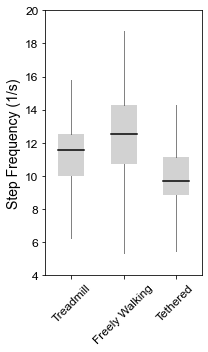

In [11]:
plot_name = 'step_freq_dist'
x_labels = ['Treadmill', 'Freely Walking', 'Tethered']

fig = plt.figure(1, figsize = [3,5])

# background boxplot
sea.boxplot(data = cat_step_freq,
               color = "gray",width = 0.5, showcaps = False, boxprops = {'edgecolor':'none','facecolor':'silver', "zorder":1, "alpha":0.7},
               showfliers=False, whiskerprops = {'linewidth':1, "zorder":10, "alpha":0.7}, medianprops=dict(color="black"))
    
# axis properties
plt.yticks(fontsize = 12, fontname = 'Arial')
plt.xticks(np.arange(3), np.array(x_labels), fontsize = 12, rotation = 45, fontname="Arial")
plt.ylabel('Step Frequency (1/s)', fontsize = 14, fontname = 'Arial')
plt.ylim([4,20])

plt.tight_layout()
plt.show()

fig.savefig(figure_dir + plot_name+'.png', dpi = 300)
fig.savefig(figure_dir + plot_name+'.svg', dpi = 300)

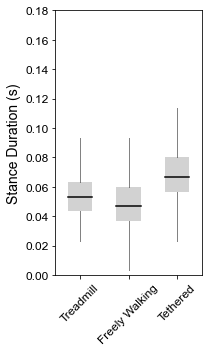

In [7]:
plot_name = 'stance_duration_dist'
x_labels = ['Treadmill', 'Freely Walking', 'Tethered']

fig = plt.figure(1, figsize = [3,5])

# background boxplot
sea.boxplot(data = cat_stance_duration,
               color = "gray",width = 0.5, showcaps = False, boxprops = {'edgecolor':'none','facecolor':'silver', "zorder":1, "alpha":0.7},
               showfliers=False, whiskerprops = {'linewidth':1, "zorder":10, "alpha":0.7}, medianprops=dict(color="black"))
    
# axis properties
plt.yticks(fontsize = 12, fontname = 'Arial')
plt.xticks(np.arange(3), np.array(x_labels), fontsize = 12, rotation = 45, fontname="Arial")
plt.ylabel('Stance Duration (s)', fontsize = 14, fontname = 'Arial')
plt.ylim([0, .18])

plt.tight_layout()
plt.show()

fig.savefig(figure_dir + plot_name+'.png', dpi = 300)
fig.savefig(figure_dir + plot_name+'.svg', dpi = 300)

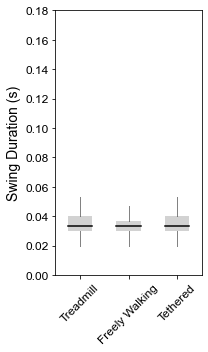

In [13]:
plot_name = 'swing_duration_dist'
x_labels = ['Treadmill', 'Freely Walking', 'Tethered']

fig = plt.figure(1, figsize = [3,5])

# background boxplot
sea.boxplot(data = cat_swing_duraiton,
               color = "gray",width = 0.5, showcaps = False, boxprops = {'edgecolor':'none','facecolor':'silver', "zorder":1, "alpha":0.7},
               showfliers=False, whiskerprops = {'linewidth':1, "zorder":10, "alpha":0.7}, medianprops=dict(color="black"))
    
# axis properties
plt.yticks(fontsize = 12, fontname = 'Arial')
plt.xticks(np.arange(3), np.array(x_labels), fontsize = 12, rotation = 45, fontname="Arial")
plt.ylabel('Swing Duration (s)', fontsize = 14, fontname = 'Arial')
plt.ylim([0,0.18])

plt.tight_layout()
plt.show()

fig.savefig(figure_dir + plot_name+'.png', dpi = 300)
fig.savefig(figure_dir + plot_name+'.svg', dpi = 300)

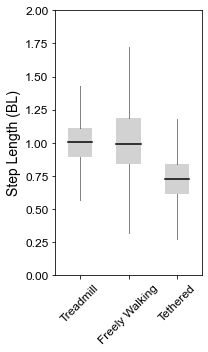

In [14]:
plot_name = 'step_length_dist'
x_labels = ['Treadmill', 'Freely Walking', 'Tethered']

fig = plt.figure(1, figsize = [3,5])

# background boxplot
sea.boxplot(data = cat_step_length,
               color = "gray",width = 0.5, showcaps = False, boxprops = {'edgecolor':'none','facecolor':'silver', "zorder":1, "alpha":0.7},
               showfliers=False, whiskerprops = {'linewidth':1, "zorder":10, "alpha":0.7}, medianprops=dict(color="black"))
    
# axis properties
plt.yticks(fontsize = 12, fontname = 'Arial')
plt.xticks(np.arange(3), np.array(x_labels), fontsize = 12, rotation = 45, fontname="Arial")
plt.ylabel('Step Length (BL)', fontsize = 14, fontname = 'Arial')
plt.ylim([0,2])

plt.tight_layout()
plt.show()

fig.savefig(figure_dir + plot_name+'.png', dpi = 300)
fig.savefig(figure_dir + plot_name+'.svg', dpi = 300)

### Inter-leg Coordination

In [35]:
# calculate mean of polar distributions by transforming them into cartesian coordinates then back to polar coordinates
def estimate_ang_stats(var):
#     mean_angle = np.arctan2(np.nanmedian(np.sin(var)), np.nanmedian(np.cos(var)))
    mean_angle = np.arctan2(np.nanmean(np.sin(var)), np.nanmean(np.cos(var)))
    angular_dispersion = np.sqrt(np.nanmean(np.sin(var))**2 + np.nanmean(np.cos(var))**2) # 0: uniform, 1: concetrated in one directtion
    return mean_angle, angular_dispersion

In [36]:
def compute_histogram(var, N):
    hist, bin_edges = np.histogram(var, bins=N, range=(0.0,2*np.pi), density=True)
    bin_centers = bin_edges[1::] - ((bin_edges[1]- bin_edges[0])/2)
    return hist, bin_centers 


In [37]:
# transform phase values to between -np.pi to np.pi
def transform_half_polar(var):
    var[var>np.pi] = var[var>np.pi] - (2*np.pi)
    return var

In [38]:
def full_distribution_transform_polar(var):
    var[var<0] = np.pi + np.abs(-np.pi - var[var<0])
    return var

In [39]:
def compute_inphase_histogram(var, N):
    hist, bin_edges = np.histogram(var, bins=N, range=(-np.pi, np.pi), density=True)
    bin_centers = bin_edges[1::] - ((bin_edges[1]- bin_edges[0])/2)
    return hist, bin_centers 

In [40]:
# function that transforms that space from 0 to pi to 0 to 2pi
def transform_polar(org_val):
    if org_val < 0: # only need to transform negative values to extend the space to 2pi
        transformed_val = np.pi + np.abs(-np.pi - org_val)
    else: 
        transformed_val = org_val
        
    return transformed_val

### Compare phase across setups disregarding walking speed

In [41]:
# relative phase distributions - to L1
relative_leg = [3, 3, 3, 3, 3] # L1-R1, L1-R2, L1-R3, L1-L2, L1-L3
inphase_comparasions = [1,4]
step_threshold = 10 # empirically determined
full_phase_dist = []

# iterate through phase comparasions
for p in range(len(relative_leg)):

    vel_data = np.transpose(parallel_vel).flatten()
    phase_data = phase[p, :, :].flatten()
    beh_ids = np.transpose(beh_class).flatten()

    # forward walking data
    fw_vel_data = vel_data[beh_ids==1]
    fw_phase_data = phase_data[beh_ids==1]

    # filter data - remove negative 1 and nan values
    filt_vel = fw_vel_data[fw_phase_data != -1]
    filt_phase = fw_phase_data[fw_phase_data != -1]

    filt_vel = filt_vel[~np.isnan(filt_phase)]
    filt_phase = filt_phase[~np.isnan(filt_phase)]

    # split phase into the different walking speed categories - rescale from 0-1 to 0-2pi
    filt_phase_adj = filt_phase*(2*np.pi)
    
    # distributions
    if p in inphase_comparasions:
        cat_phase = transform_half_polar(filt_phase_adj)
    else:
        cat_phase = filt_phase_adj
        
    full_phase_dist.append(cat_phase)



In [42]:
N_Tread = int(np.mean(np.array([len(full_phase_dist[0]), len(full_phase_dist[1]), len(full_phase_dist[2]), len(full_phase_dist[3]), len(full_phase_dist[4])])))
print('Treadmill: N = ', N_Tread)

# Load data from the other setups
phase_data_dir = datadir +'phase_data/'
L1_R1_ball = np.load(phase_data_dir + 'R1_relative_phase_ball_2024-01-25.npy')*(2*np.pi)
L1_R2_ball = transform_half_polar(np.load(phase_data_dir + 'R2_relative_phase_ball_2024-01-25.npy')*(2*np.pi))
L1_R3_ball = np.load(phase_data_dir + 'R3_relative_phase_ball_2024-01-25.npy')*(2*np.pi)
L1_L2_ball = np.load(phase_data_dir + 'L2_relative_phase_ball_2024-01-25.npy')*(2*np.pi)
L1_L3_ball = transform_half_polar(np.load(phase_data_dir + 'L3_relative_phase_ball_2024-01-25.npy')*(2*np.pi))

N_ball = int(np.mean(np.array([len(L1_R1_ball), len(L1_R2_ball), len(L1_R3_ball), len(L1_L2_ball), len(L1_L3_ball)])))
print('Tethered: N = ', N_ball)

L1_R1_fw = np.load(phase_data_dir + 'L1_R1_FB_v3.npy')
L1_R2_fw = np.load(phase_data_dir + 'L1_R2_FB_v3.npy')
L1_R3_fw = np.load(phase_data_dir + 'L1_R3_FB_v3.npy')
L1_L2_fw = np.load(phase_data_dir + 'L1_L2_FB_v3.npy')
L1_L3_fw = np.load(phase_data_dir + 'L1_L3_FB_v3.npy')

N_FW = int(np.mean(np.array([len(L1_R1_fw), len(L1_R2_fw), len(L1_R3_fw), len(L1_L2_fw), len(L1_L3_fw)])))
print('Freely Walking: N = ', N_FW)


# concatenate data
phase_combined = [[full_phase_dist[0], L1_R1_fw, L1_R1_ball], [full_phase_dist[1], L1_R2_fw, L1_R2_ball], 
                  [full_phase_dist[2], L1_R3_fw, L1_R3_ball], [full_phase_dist[3], L1_L2_fw, L1_L2_ball], 
                  [full_phase_dist[4], L1_L3_fw, L1_L3_ball]]

Treadmill: N =  1418
Tethered: N =  1062
Freely Walking: N =  610


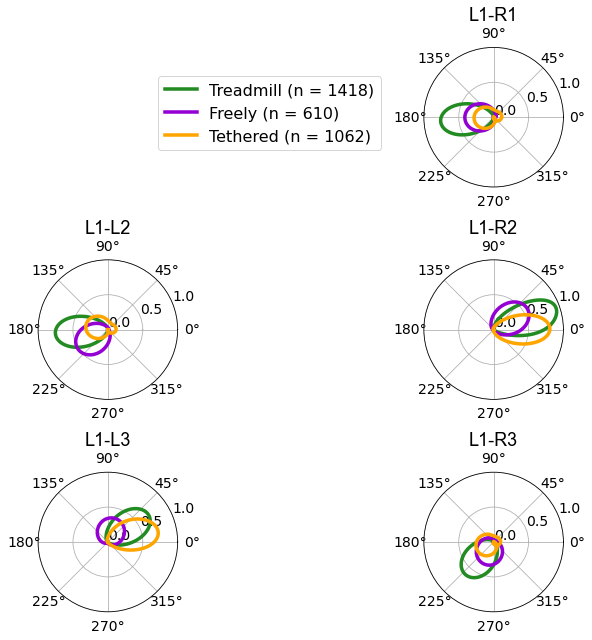

In [45]:
# plot distrbutions on the same plot
# plot relative phase to L1 - histograms
compare_labels = ['L1-R1', 'L1-R2', 'L1-R3','L1-L2', 'L1-L3']
plt_colors = ['forestgreen', 'darkviolet', 'orange']
plt_axes = [[0,1],[1,1],[2,1],[1,0],[2,0]]
setup_labels = ['Treadmill (n = 1418)', 'Freely (n = 610)', 'Tethered (n = 1062)']

fig, axs = plt.subplots(3,2, figsize =[8,9], sharex=True, sharey=True, subplot_kw={'projection': 'polar'})
for p in range(len(phase_combined)):
    for j in range(3): # setups
                
        # plot distribution
        sea.kdeplot(ax= axs[plt_axes[p][0], plt_axes[p][1]], x=phase_combined[p][j], color = plt_colors[j], linewidth = 3.5, zorder=10, label = setup_labels[j], bw_adjust=2.5) 
        
#         # plot mean 
#         mean_phase, _ = estimate_ang_stats(phase_combined[p][j])
#         axs[plt_axes[p][0], plt_axes[p][1]].plot(np.array([0, mean_phase]), np.array([0, 1]), color = plt_colors[j], linewidth = 3.5, zorder=5, alpha = 1)
        
        
    # plot parameters
    axs[plt_axes[p][0], plt_axes[p][1]].tick_params(axis='both', labelsize=14)
    axs[plt_axes[p][0], plt_axes[p][1]].set_ylabel(None)
    axs[plt_axes[p][0], plt_axes[p][1]].set_title(compare_labels[p], fontsize=18, fontname="Arial")
    axs[plt_axes[p][0], plt_axes[p][1]].set_rticks(np.arange(0,1.01,0.5))
    
    if p ==0:
        axs[plt_axes[p][0], plt_axes[p][1]].legend(fontsize = 16, bbox_to_anchor=(-0.25, 0.85))
        
axs[0,0].axis('off')
plt.tight_layout()
plt.show()

fig.savefig(figure_dir + 'phase_comparisons_setups.png', dpi = 300)
fig.savefig(figure_dir + 'phase_comparisons_setups.svg', dpi = 300)

### Step order within a tripod group

##### Categories:

###### Front Leg Leads:

0 = H>M>F

1 = M>H>F

2 = M=H > F

###### Middle Leg Leads:

3 = F>H>M

4 = H>F>M

5 = F=H > M

###### Hind Leg Leads

6 = F>M>H 

7 = F=M>H

8 = F > M=H 

9 = M>F>H

###### True Tripod

10 = F=M=H



In [49]:
# Determine Step order of the legs within a tripod
leg_order_classification = []
for trial in range(phase[0].shape[1]):
    # Right Tripod Legs
    l1_r1_idxs = np.where(np.logical_and.reduce((phase[0][:,trial] != -1, ~np.isnan(phase[0][:,trial]), beh_class[trial, :] == 1)) == True)[0]
    l1_l2_idxs = np.where(np.logical_and.reduce((phase[3][:,trial] != -1, ~np.isnan(phase[3][:,trial]), beh_class[trial, :] == 1)) == True)[0]
    l1_r3_idxs = np.where(np.logical_and.reduce((phase[2][:,trial] != -1, ~np.isnan(phase[2][:,trial]), beh_class[trial, :] == 1)) == True)[0]
    r_same_idxs = np.intersect1d(l1_r3_idxs, np.intersect1d(l1_r1_idxs, l1_l2_idxs))

    if len(r_same_idxs) > 0: # common frames were detected
        # phase values for right tripod legs
        l1_r1_trial_vals = phase[0][r_same_idxs,trial]
        l1_l2_trial_vals = phase[3][r_same_idxs,trial]
        l1_r3_trial_vals = phase[2][r_same_idxs,trial]

        # Classify step order into categories
        for j in range(len(l1_r1_trial_vals)):
            if (l1_r1_trial_vals[j] > l1_l2_trial_vals[j]) and (l1_l2_trial_vals[j] > l1_r3_trial_vals[j]):
                leg_order_classification.append(7)
            elif (l1_r1_trial_vals[j] > l1_r3_trial_vals[j]) and (l1_r3_trial_vals[j] > l1_l2_trial_vals[j]):
                leg_order_classification.append(4)
            elif (l1_r1_trial_vals[j] == l1_l2_trial_vals[j]) and (l1_l2_trial_vals[j] > l1_r3_trial_vals[j]):
                leg_order_classification.append(8)
            elif (l1_r3_trial_vals[j] == l1_l2_trial_vals[j]) and (l1_r3_trial_vals[j] < l1_r1_trial_vals[j]):
                leg_order_classification.append(9)
            elif (l1_l2_trial_vals[j] > l1_r1_trial_vals[j]) and (l1_r1_trial_vals[j] > l1_r3_trial_vals[j]):
                leg_order_classification.append(10)
            elif (l1_l2_trial_vals[j] > l1_r3_trial_vals[j]) and (l1_r3_trial_vals[j] > l1_r1_trial_vals[j]):
                leg_order_classification.append(1)
            elif (l1_r3_trial_vals[j] > l1_r1_trial_vals[j]) and (l1_r1_trial_vals[j] > l1_l2_trial_vals[j]):
                leg_order_classification.append(5)
            elif (l1_r3_trial_vals[j] > l1_l2_trial_vals[j]) and (l1_l2_trial_vals[j] > l1_r1_trial_vals[j]):
                leg_order_classification.append(0)
            elif (l1_r1_trial_vals[j] == l1_r3_trial_vals[j]) and (l1_r3_trial_vals[j] > l1_l2_trial_vals[j]):
                leg_order_classification.append(6)
            elif (l1_r3_trial_vals[j] == l1_l2_trial_vals[j]) and (l1_r3_trial_vals[j] > l1_r1_trial_vals[j]):
                leg_order_classification.append(2)
            elif (l1_r1_trial_vals[j] == l1_l2_trial_vals[j]) and (l1_r3_trial_vals[j] > l1_l2_trial_vals[j]):
                leg_order_classification.append(3)
            elif (l1_r3_trial_vals[j] == l1_l2_trial_vals[j]) and (l1_l2_trial_vals[j] == l1_r1_trial_vals[j]):
                leg_order_classification.append(11)

    # Left Tripod Legs
    l1_r2_idxs = np.where(np.logical_and.reduce((phase[1][:,trial] != -1, ~np.isnan(phase[1][:,trial]), beh_class[trial, :] == 1)) == True)[0]
    l1_l3_idxs = np.where(np.logical_and.reduce((phase[4][:,trial] != -1, ~np.isnan(phase[4][:,trial]), beh_class[trial, :] == 1)) == True)[0]
    l_same_idxs = np.intersect1d(l1_r2_idxs, l1_l3_idxs)

    if len(l_same_idxs) > 0:
        # phase values for left tripod legs
        l1_r2_trial_vals = phase[1][l_same_idxs,trial]
        l1_l3_trial_vals = phase[4][l_same_idxs,trial]

        # correct for the wrap around
        l1_r2_trial_vals[l1_r2_trial_vals >= 0.5] = l1_r2_trial_vals[l1_r2_trial_vals >= 0.5] -1
        l1_l3_trial_vals[l1_l3_trial_vals >= 0.5] = l1_l3_trial_vals[l1_l3_trial_vals >= 0.5] -1

        # Classify step order into categories
        for j in range(len(l1_r2_trial_vals)):
            if (0 > l1_r2_trial_vals[j]) and (l1_r2_trial_vals[j] > l1_l3_trial_vals[j]):
                leg_order_classification.append(7)
            elif (0 > l1_l3_trial_vals[j]) and (l1_l3_trial_vals[j] > l1_r2_trial_vals[j]):
                leg_order_classification.append(4)
            elif (0 == l1_r2_trial_vals[j]) and (l1_r2_trial_vals[j] > l1_l3_trial_vals[j]):
                leg_order_classification.append(8)
            elif (l1_l3_trial_vals[j] == l1_r2_trial_vals[j]) and (l1_l3_trial_vals[j] < 0): # front leg occurs last
                leg_order_classification.append(9)
            elif (l1_r2_trial_vals[j] > 0) and (0 > l1_l3_trial_vals[j]):
                leg_order_classification.append(10)
            elif (l1_r2_trial_vals[j] > l1_l3_trial_vals[j]) and (l1_l3_trial_vals[j] > 0):
                leg_order_classification.append(1)
            elif (l1_l3_trial_vals[j] > 0) and (0 > l1_r2_trial_vals[j]):
                leg_order_classification.append(5)
            elif (l1_l3_trial_vals[j] > l1_r2_trial_vals[j]) and (l1_r2_trial_vals[j] > 0):
                leg_order_classification.append(0)
            elif (0 == l1_l3_trial_vals[j]) and (l1_l3_trial_vals[j] > l1_r2_trial_vals[j]):
                leg_order_classification.append(6)
            elif (l1_l3_trial_vals[j] == l1_r2_trial_vals[j]) and (l1_l3_trial_vals[j] > 0):
                leg_order_classification.append(2)
            elif (0 == l1_r2_trial_vals[j]) and (l1_l3_trial_vals[j] > 0):
                leg_order_classification.append(3)
            elif (l1_l3_trial_vals[j] == l1_r2_trial_vals[j]) and (l1_r2_trial_vals[j] == 0):
                leg_order_classification.append(11)

# convery into an array
leg_order_classification = np.array(leg_order_classification)
print('Number of Steps = ', len(leg_order_classification))

# determine the proportion of each category represented
category_proportion = np.zeros(12)

for j in range(len(category_proportion)):
    category_proportion[j] = len(np.where(leg_order_classification == j)[0])/len(leg_order_classification)
    

Number of Steps =  2706


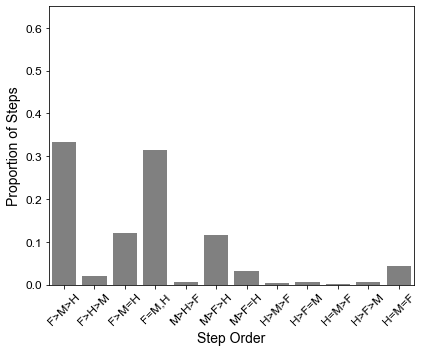

In [51]:
# Plot the proportion of each step type
cat_names = ['F>M>H', 'F>H>M','F>M=H', 'F=M,H', 'M>H>F', 'M>F>H', 'M>F=H', 'H>M>F', 'H>F=M', 'H=M>F', 'H>F>M', 'H=M=F']

fig = plt.figure(1, figsize =  [6,5])
sea.barplot(x= np.arange(0,12), y = category_proportion, color = 'gray')
plt.yticks(fontsize = 12, fontname = 'Arial')
plt.xticks(np.arange(0,12), cat_names, fontsize = 12, fontname = 'Arial', rotation = 45)
plt.ylabel('Proportion of Steps', fontsize = 14, fontname = 'Arial')
plt.xlabel('Step Order', fontsize = 14, fontname = 'Arial')
plt.ylim([0,0.65])
plt.tight_layout()
plt.show()

fig.savefig(figure_dir + 'step_order.png', dpi = 300)
fig.savefig(figure_dir + 'step_order.pdf', dpi = 300)
fig.savefig(figure_dir + 'step_order.svg', dpi = 300)

### IAV-GAL4 comparasion to split-GAL4 control

In [2]:
results_dir = 'C:/Users/pratt/Desktop/Analysis/LINEAR_BELT_RESULTS/results/'

# # Kir 2.1 effector
genotypes = ['52A01_DBD_kir', 'iav_kir']
genotype_plot_name = ['Split-Half > Kir 2.1', 'IAV > Kir 2.1']
save_name_dir = 'iav_ctrl_kir'

#Tnt LC
# genotypes = ['52A01_DBD_tnt', 'iav_tnt']
# genotype_plot_name = ['Split-Half > tnt.LC', 'IAV > tnt.LC']
# save_name_dir = 'iav_ctrl_tnt'

figure_dir = 'H:/.shortcut-targets-by-id/10pxdlRXtzFB-abwDGi0jOGOFFNm3pmFK/Tuthill Lab Shared/manuscripts/treadmill_2023/figures/raw/iav/'

# intialize variables
meta_matrix_compare = []
beh_class_compare = []
heading_angle_compare = []
parallel_vel_compare = []
body_height_walking_compare = []
step_distance_compare = []
step_length_compare = []
step_freq_compare = []
stance_duration_compare = []
swing_duration_compare = [] 
phase_compare = []
nlegs_stance_walking_compare = []
body_positions_compare = []

for j in range(len(genotypes)):
    meta_matrix_compare.append(np.load(results_dir + genotypes[j] + '_meta_matrix.npy', allow_pickle=True))
    beh_class_compare.append(np.load(results_dir + genotypes[j] + '_behavior_classification.npy', allow_pickle=True))
    heading_angle_compare.append(np.load(results_dir + genotypes[j] + '_heading_angle.npy', allow_pickle=True))
    parallel_vel_compare.append(np.load(results_dir + genotypes[j] + '_parallel_velocity.npy', allow_pickle=True))
    body_height_walking_compare.append(np.load(results_dir + genotypes[j] + '_body_height_walking.npy', allow_pickle=True))
    step_distance_compare.append(np.load(results_dir + genotypes[j] + '_step_distance.npy', allow_pickle=True))
    step_freq_compare.append(np.load(results_dir + genotypes[j] + '_step_frequency.npy', allow_pickle=True))
    stance_duration_compare.append(np.load(results_dir + genotypes[j] + '_stance_duration.npy', allow_pickle=True))
    swing_duration_compare.append(np.load(results_dir + genotypes[j] + '_swing_duration.npy', allow_pickle=True))
    phase_compare.append(np.load(results_dir + genotypes[j] + '_phase.npy', allow_pickle=True))
    nlegs_stance_walking_compare.append(np.load(results_dir + genotypes[j] + '_number_legs_in_stance_walking.npy', allow_pickle=True))
    body_positions_compare.append(np.load(results_dir + genotypes[j] + '_body_positions.npy', allow_pickle=True))
    step_length_compare.append(np.load(results_dir + genotypes[j] + '_step_length.npy', allow_pickle=True))


### IAV > kir2.1 driving speed

In [203]:
driving_speeds = np.unique(meta_matrix_compare[1][:, 2]).tolist()
flies = np.unique(meta_matrix_compare[1][:, 0]).astype(int).tolist()#[0:10]
walking_speed_dists = []
walking_speed_stats = np.zeros((len(flies), len(driving_speeds))) 
d_cnt = -1
for j in driving_speeds:
    d_cnt += 1
    for fly in flies:
        fly_idxs = meta_matrix_compare[1][:, 0] == fly
        driving_speed_idxs = meta_matrix_compare[1][:, 2] == j
        trial_idxs = np.logical_and.reduce((fly_idxs, driving_speed_idxs))
        
        # velocities and forward walking
        vels = parallel_vel_compare[1][trial_idxs,:].flatten()
        beh_ids = beh_class_compare[1][trial_idxs, :].flatten()
        
        fw_vels = vels[beh_ids==1]
        
        # filter our nans
        filt_fw_vels = fw_vels[~np.isnan(fw_vels)]
        
        # compute stats
        walking_speed_stats[fly-1, d_cnt] = np.nanmedian(filt_fw_vels)
        
        # store distribution data
        if fly ==1:
            vel_dist = filt_fw_vels
        else:
            vel_dist = np.concatenate((vel_dist, filt_fw_vels))
            
    walking_speed_dists.append(vel_dist)
        

C:\Users\pratt\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


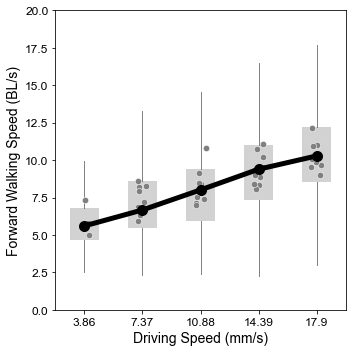

In [222]:
# plot driving speed by walking speed
jitter_val = 0.1
fig = plt.figure(1, figsize = [5,5])

# background boxplot
sea.boxplot(data = walking_speed_dists,
               color = "gray",width = 0.5, showcaps = False, boxprops = {'edgecolor':'none','facecolor':'silver', "zorder":1, "alpha":0.7},
               showfliers=False, whiskerprops = {'linewidth':1, "zorder":10, "alpha":0.7}, medianprops=dict(color="none"))

for j in range(len(driving_speeds)):
    curr_speed = driving_speeds[j]
    fly_speed =  walking_speed_stats[:,j]
    x_jitter = (j)+ np.random.choice([-1,1],size=len(fly_speed))*np.random.uniform(low=0.0, high=jitter_val, size=len(fly_speed))
    sea.scatterplot(x=x_jitter, y=fly_speed, color = 'gray', s = 40, alpha = 1, zorder = 10)

# mean speed
plt.plot(np.arange(0,len(driving_speeds)), mean_fly_speed, color ='black', marker='.', markersize = 20, linewidth = 5, alpha = 1, zorder = 25)
    
# axis properties
plt.yticks(fontsize = 12, fontname = 'Arial')
plt.xticks(np.arange(len(driving_speeds)), np.array(driving_speeds).astype(str), fontsize = 12, rotation = 0, fontname="Arial")
plt.xlabel('Driving Speed (mm/s)', fontsize = 14, fontname = 'Arial')
plt.ylabel('Forward Walking Speed (BL/s)', fontsize = 14, fontname = 'Arial')
plt.ylim([0,20])

plt.tight_layout()
plt.show()

fig.savefig(figure_dir + 'iav_driving_walking_speed_v2.png', dpi = 300)
fig.savefig(figure_dir + 'iav_driving_walking_speed_v2.svg', dpi = 300)

### Examine overall walking patterns - burstiness and occupancy probability

#### Burstiness

In [234]:
FS = 180
chamber_center = 8.929/2 # equavalent to a break beam
mean_burst_store = []
fly_burst_store = []

for g in [0,1]:
    body_x = np.transpose(body_positions_compare[g][3,:,:])
    flies = np.unique(meta_matrix_compare[g][:, 0]).astype(int).tolist()
    driving_speeds = np.unique(meta_matrix_compare[g][:, 2]).tolist()
    fly_burst_frequency = np.zeros((len(flies), len(driving_speeds))) # flies, driving speeds
    mean_burst_frequency = np.zeros(len(driving_speeds)) # flies, driving speeds
    speed_cnt = -1
    trial_adj = np.array([0, FS, FS*2, FS*3, FS*4])


    for speed in driving_speeds:
        speed_cnt += 1
        speed_idxs = meta_matrix_compare[g][:, 2] ==speed
        for fly in flies:
            fly_idxs = meta_matrix_compare[g][:, 0] ==fly

            filt_idxs = np.logical_and.reduce((fly_idxs, speed_idxs))

            fly_body_x = body_x[filt_idxs ,:]
            fly_BL = meta_matrix_compare[g][filt_idxs , -1]
            fly_beh_class = beh_class_compare[g][filt_idxs , :]

            for j in range(fly_body_x.shape[0]): # iterate through trials and find the idxs of when the cross occured
                trial_x = fly_body_x[j, trial_adj[speed_cnt]:-1] * fly_BL[j] # mm
                trial_class = fly_beh_class[j, trial_adj[speed_cnt]:-1]

                # determine idxs of crossing events
                crossing_class = np.zeros(len(trial_x))
                crossing_class[trial_x>chamber_center] = 1
                diff_class = np.diff(crossing_class)
                diff_class[trial_class[1::]==8] = 0 # remove crossing events if they occured while the fly was upside down
                n_crossings = len(np.where(diff_class==1)[0])
                n_frames = len(np.where(trial_class[1::]!=8)[0])

                if j == 0:
                    tot_crossing = n_crossings
                    tot_time = n_frames/180
                else:
                    tot_crossing += n_crossings
                    tot_time += n_frames/180

            # save freq for each fly
            fly_burst_frequency[fly-1, speed_cnt] = tot_crossing/tot_time

            if fly == 1:
                mean_tot_crossing = tot_crossing
                mean_tot_time = tot_time
            else:
                mean_tot_crossing += tot_crossing
                mean_tot_time += tot_time

        # mean burst frequency
        mean_burst_frequency[speed_cnt] = mean_tot_crossing/mean_tot_time
        
    # store genotype variables
    mean_burst_store.append(mean_burst_frequency)
    fly_burst_store.append(fly_burst_frequency)
        
                

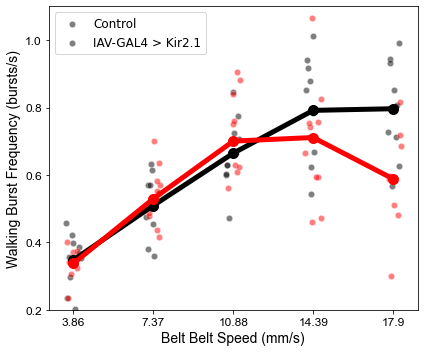

In [242]:
# plot burstiness - simple means
jitter_val = 0.1
w_adj = 0.25
g_colors = ['black', 'red']

fig = plt.figure(1, figsize =[6,5])

for g in range(2):
    for j in range(len(driving_speeds)):
        curr_speed = driving_speeds[j]
        speed_fly_bursts =  fly_burst_store[g][:,j]
        x_jitter = (j+1)+ np.random.choice([-1,1],size=len(speed_fly_bursts))*np.random.uniform(low=0.0, high=jitter_val, size=len(speed_fly_bursts))
        sea.scatterplot(x=x_jitter, y=speed_fly_bursts, color = g_colors[g], s = 40, alpha = 0.5)

        # plot mean 
        # mean speed
    plt.plot(np.arange(1,len(driving_speeds)+1), mean_burst_store[g], color =g_colors[g], marker='.', markersize = 20, linewidth = 5, alpha = 1, zorder = 25)
    #     sea.lineplot(x=np.array([(j+1)-w_adj,(j+1)+w_adj]), y=np.array([mean_burst_frequency[j], mean_burst_frequency[j]]), color = 'black', linewidth = 4, alpha =1)

# axes
plt.ylabel('Walking Burst Frequency (bursts/s)', fontname ='Arial', fontsize = 14)
plt.xlabel('Belt Belt Speed (mm/s)', fontname = 'Arial', fontsize = 14)
plt.xticks(np.arange(1,6), np.array(driving_speeds).astype(str), fontsize = 12, rotation = 0, fontname="Arial")
plt.yticks(fontsize = 12, fontname = 'Arial')
plt.legend(['Control', 'IAV-GAL4 > Kir2.1'], fontsize = 12)
plt.ylim([0.2,1.1])
plt.tight_layout()
plt.show()

fig.savefig(figure_dir + 'burst_freq.png', dpi = 300)
fig.savefig(figure_dir + 'burst_freq.svg', dpi = 300)

#### Occupany Probability

In [266]:
g = 1
FS = 180
chamber_position_bins = np.linspace(0, 8.929, 20)
bin_centers = np.round(chamber_position_bins[0:-1] + ((chamber_position_bins[1] - chamber_position_bins[0])/2), 2)
tx = np.transpose(np.copy(body_positions_compare[g][3,:,:]))
trial_adj = np.array([0, FS, FS*2, FS*3, FS*4])
for j in range(tx.shape[0]):
    tx[j,:] = tx[j,:] * meta_matrix_compare[g][j,-1]
driving_speeds = np.unique(meta_matrix_compare[g][:,2])
prob_occupancy = np.zeros((len(chamber_position_bins)-1, len(driving_speeds)))
ave_speed = np.zeros((len(chamber_position_bins)-1, len(driving_speeds)))
speed_cnt = -1
for speed in driving_speeds.tolist():  
    speed_cnt += 1
    trial_idxs = np.where(meta_matrix_compare[g][:,2] == speed)[0]
    trial_behs = beh_class_compare[g][trial_idxs,trial_adj[speed_cnt]:-1].flatten()
    trial_tx = tx[trial_idxs,trial_adj[speed_cnt]:-1].flatten()
    trial_speeds = parallel_vel_compare[g][trial_idxs,trial_adj[speed_cnt]:-1].flatten()
    
    # filter x position
    filt_x = trial_tx[np.where(trial_behs<8)[0]]# remove the upside down case
    filt_vel = trial_speeds[np.where(trial_behs<8)[0]]
    
    for j in range(len(chamber_position_bins)-1):
        ave_speed[j,speed_cnt] = np.nanmean(filt_vel[np.logical_and(filt_x>chamber_position_bins[j], filt_x<chamber_position_bins[j+1])])
        prob_occupancy[j, speed_cnt] = len(filt_x[np.logical_and(filt_x>chamber_position_bins[j], filt_x<chamber_position_bins[j+1])]) 
    
    prob_occupancy[:, speed_cnt] =  prob_occupancy[:, speed_cnt]/np.sum(prob_occupancy[:, speed_cnt])
        

C:\Users\pratt\AppData\Local\Temp\ipykernel_7696\4287608389.py:25: RuntimeWarning: Mean of empty slice
  ave_speed[j,speed_cnt] = np.nanmean(filt_vel[np.logical_and(filt_x>chamber_position_bins[j], filt_x<chamber_position_bins[j+1])])


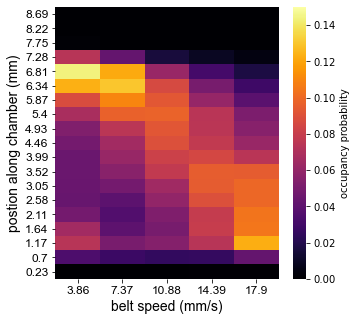

In [267]:
# plot the heatmap
fig = plt.figure(1, figsize = [5,5])
heatmap = sea.heatmap(prob_occupancy, cmap = 'inferno',cbar_kws={'label': 'occupancy probability'}, vmin=0, vmax=0.15)
plt.xticks(np.arange(0,5)+0.5, driving_speeds, fontsize = 12, fontname = 'arial')
plt.yticks(np.arange(0,19)+0.5, bin_centers, fontsize = 12, fontname = 'arial', rotation = 0)
plt.ylabel('postion along chamber (mm)', fontsize = 14, fontname = 'arial')
plt.xlabel('belt speed (mm/s)', fontsize = 14, fontname = 'arial')
plt.gca().invert_yaxis()
plt.show()
fig.savefig(figure_dir + 'iav_prob_occupancy.png', dpi = 300)
fig.savefig(figure_dir + 'iav_prob_occupancy.svg', dpi = 300)

# fig.savefig(figure_dir + 'control_prob_occupancy.png', dpi = 300)
# fig.savefig(figure_dir + 'control_prob_occupancy.svg', dpi = 300)

### Intralimb kinematic Comparison

In [14]:
def intralimb_kinematic_distrbutions_comparison(metric, w_vel, n_step_threshold, meta_matrix, beh_class):

    # iterate through legs 
    leg_dists = [] # front, middle, hind
    for leg in range(3):
        dist_cnt = 0
        for fly in np.unique(meta_matrix[:, 0]).astype(int).tolist():#:[0:10]:
            trial_idxs = np.where(meta_matrix[:, 0] == fly)[0]

            # extract data
            vel_data = w_vel[trial_idxs,:].flatten()
            leg1_data = metric[leg, :, trial_idxs].flatten() # doesn't need to be transposed
            leg2_data = metric[leg+3, :, trial_idxs].flatten()

            # behavior classifier
            beh_ids = beh_class[trial_idxs, :].flatten()

            # filter for forward walking behavior == 1
            fw_vel_data = vel_data[beh_ids==1]
            fw_leg1_data = leg1_data[beh_ids==1]
            fw_leg2_data = leg2_data[beh_ids==1]

            # concatenate data
            cat_vel = np.concatenate((fw_vel_data, fw_vel_data))
            cat_data = np.concatenate((fw_leg1_data, fw_leg2_data))

            # filter concatenated data to remove Nans
            filter_vels = cat_vel[~np.isnan(cat_data)]
            filter_data  = cat_data[~np.isnan(cat_data)]

            # filter out -1 values
            filter_vels = filter_vels[~(filter_data ==-1)]
            filter_data = filter_data[~(filter_data ==-1)]

            # if there are a sufficient number of steps then store data as a distribution
            if len(filter_data) >= n_step_threshold:
                if dist_cnt == 0:
                    data_dist = filter_data
                    vel_dist = filter_vels
                    fly_dist = fly*np.ones(len(filter_data))
                    dist_cnt = 1
                else:
                    data_dist = np.concatenate((data_dist, filter_data))
                    vel_dist = np.concatenate((vel_dist, filter_vels))
                    fly_dist = np.concatenate((fly_dist, fly*np.ones(len(filter_data))))

        # stack data
        all_data = np.vstack((fly_dist, vel_dist, data_dist))
        leg_dists.append(all_data)
    
    return leg_dists   

In [15]:
# compute distributions for intralimb kinematics
# filtering parameters
n_step_threshold = 15 # need at least 15 steps from a fly

step_freq_comparison = []
step_distance_comparison = []

for j in range(len(step_freq_compare)):
    step_freq_comparison.append(intralimb_kinematic_distrbutions_comparison(step_freq_compare[j], parallel_vel_compare[j], n_step_threshold, meta_matrix_compare[j], beh_class_compare[j]))
    step_distance_comparison.append(intralimb_kinematic_distrbutions_comparison(step_length_compare[j], parallel_vel_compare[j], n_step_threshold, meta_matrix_compare[j], beh_class_compare[j]))

#### Regression fits

In [55]:
def plot_marginal_intralimb_comparison(plot_metric, p_coeff, plot_scatter, ylabel_name, metric_name, ylim, add_offset, offset_val):
    # plot intralimb metrics
    leg_pairs = ['Front Legs', 'Middle Legs', 'Hind Legs']
    gen_colors = ['black', 'red']
    for leg in range(3):
        g = sea.JointGrid()
        for j in range(len(plot_metric)):
            vel_fit = np.linspace(np.min(plot_metric[j][leg][1,:]), np.max(plot_metric[j][leg][1,:]), 100)
            p = np.polyfit(plot_metric[j][leg][1,:], plot_metric[j][leg][2,:], p_coeff) # estimated coefficents...least squares polynomial fit
            y_fit = np.polyval(p, vel_fit)
            sea.lineplot(x=vel_fit, y=y_fit, color = gen_colors[j], linewidth = 2.5, alpha =1, ax=g.ax_joint)

        # scatter
        if plot_scatter:
            for j in range(len(plot_metric)):
                if j == 0:
                    sea.scatterplot(x=plot_metric[j][leg][1,:], y=plot_metric[j][leg][2,:], color = gen_colors[j], s = 5, alpha = 0.25, ax=g.ax_joint)
                else:
                    if add_offset:
                        sea.scatterplot(x=plot_metric[j][leg][1,:], y=plot_metric[j][leg][2,:]+offset_val, color = gen_colors[j], s = 5, alpha = 0.25, ax=g.ax_joint)
                    else:
                        sea.scatterplot(x=plot_metric[j][leg][1,:], y=plot_metric[j][leg][2,:], color = gen_colors[j], s = 5, alpha = 0.25, ax=g.ax_joint)
                    
                    
        # plot for each fly 
        for j in range(len(plot_metric)):
            unique_flies = np.unique(plot_metric[j][leg][0,:]).tolist()#[0:10]
            for fly in unique_flies:
                fly_idxs = np.where(plot_metric[j][leg][0,:]==fly)[0] 
                if len(fly_idxs) > 5:
                    vel_fit = np.linspace(np.min(plot_metric[j][leg][1,fly_idxs]), np.max(plot_metric[j][leg][1,fly_idxs]), 100)
                    p = np.polyfit(plot_metric[j][leg][1,fly_idxs], plot_metric[j][leg][2,fly_idxs], p_coeff) # estimated coefficents...least squares polynomial fit
                    y_fit = np.polyval(p, vel_fit)
                    sea.lineplot(x=vel_fit, y=y_fit, color = gen_colors[j], linewidth = 1, alpha =0.5, ax=g.ax_joint)

        # global fits
        n_steps = np.zeros(len(plot_metric))
        r2_vals = np.zeros(len(plot_metric))
        for j in range(len(plot_metric)):
            n_steps[j] = len(plot_metric[j][leg][1,:])
            vel_fit = np.linspace(np.min(plot_metric[j][leg][1,:]), np.max(plot_metric[j][leg][1,:]), 100)
            p = np.polyfit(plot_metric[j][leg][1,:], plot_metric[j][leg][2,:], p_coeff) # estimated coefficents...least squares polynomial fit
            y_fit = np.polyval(p, vel_fit)
            r2_vals[j] = np.around(r2_score(plot_metric[j][leg][2,:], np.polyval(p, plot_metric[j][leg][1,:])),2)
            sea.lineplot(x=vel_fit, y=y_fit, color = gen_colors[j], linewidth = 2.5, alpha =1, ax=g.ax_joint)

        # kde propability - speed and metric
        for j in range(len(plot_metric)):
            sea.kdeplot(x=plot_metric[j][leg][1,:], linewidth=2, color = gen_colors[j], ax=g.ax_marg_x, alpha = 0.5)
            sea.kdeplot(y=plot_metric[j][leg][2,:], linewidth=2, color = gen_colors[j], ax=g.ax_marg_y, alpha = 0.5)


        # legend and plotting parameters
        legend_text = ['Split_Half > Kir 2.1 (steps = '+str(int(n_steps[0]))+', $R^{2}$ ='+ str(r2_vals[0]) + ')', 'IAV > Kir 2.1 (steps = '+str(int(n_steps[1]))+', $R^{2}$ ='+ str(r2_vals[1]) + '))']
        g.ax_joint.legend(legend_text, fontsize = 12, bbox_to_anchor=(1.0, 1.5))
        g.ax_joint.set_xlabel('Forward Walking Speed (BL/s)', fontsize=14, fontname ='Arial')
        g.ax_joint.set_ylabel(ylabel_name, fontsize=14, fontname ='Arial')
        g.ax_joint.tick_params(axis='both', labelsize=14)
        g.ax_joint.set_title(leg_pairs[leg], fontsize = 22, fontname = 'Arial' , y=1.0, pad=-14)
        g.ax_joint.set_xlim([0,20])
        g.ax_joint.set_ylim([ylim[0],ylim[1]])
        plt.tight_layout()
        plt.show()

        fig_name = metric_name + '_'+leg_pairs[leg] + '_comparison'
        g.savefig(figure_dir + fig_name+'.png', dpi = 300)
        g.savefig(figure_dir + fig_name+'.svg', dpi = 300)

#### Bin speed averages

In [41]:
def plot_marginal_intralimb_comparison(plot_metric, p_coeff, plot_scatter, ylabel_name, metric_name, ylim, add_offset, offset_val):
    # plot intralimb metrics
    leg_pairs = ['Front Legs', 'Middle Legs', 'Hind Legs']
    gen_colors = ['black', 'red']
    for leg in range(3):
        g = sea.JointGrid()
        # scatter
        if plot_scatter:
            for j in range(len(plot_metric)):
                if j == 0:
                    sea.scatterplot(x=plot_metric[j][leg][1,:], y=plot_metric[j][leg][2,:], color = gen_colors[j], s = 5, alpha = 0.25, ax=g.ax_joint)
                else:
                    if add_offset:
                        sea.scatterplot(x=plot_metric[j][leg][1,:], y=plot_metric[j][leg][2,:]+offset_val, color = gen_colors[j], s = 5, alpha = 0.25, ax=g.ax_joint)
                    else:
                        sea.scatterplot(x=plot_metric[j][leg][1,:], y=plot_metric[j][leg][2,:], color = gen_colors[j], s = 5, alpha = 0.25, ax=g.ax_joint)
                    
                    
        # global fits
        n_steps = np.zeros(len(plot_metric))
        r2_vals = np.zeros(len(plot_metric))
        for j in range(len(plot_metric)):
            n_steps[j] = len(plot_metric[j][leg][1,:])
            vel_fit = np.linspace(np.min(plot_metric[j][leg][1,:]), np.max(plot_metric[j][leg][1,:]), 100)
            p = np.polyfit(plot_metric[j][leg][1,:], plot_metric[j][leg][2,:], p_coeff) # estimated coefficents...least squares polynomial fit
            y_fit = np.polyval(p, vel_fit)
            r2_vals[j] = np.around(r2_score(plot_metric[j][leg][2,:], np.polyval(p, plot_metric[j][leg][1,:])),2)


        #average speed bins instead of fitting
        bin_size = 2
        speed_start = 4 # BL/s
        speed_end = 15.5 # BL/s
        bin_edges = np.arange(speed_start, speed_end, bin_size)
        ave_fits = np.zeros((3, len(bin_edges), 2)) # leg pairs, number of bins, mean + 95% confidence
        for j in range(len(plot_metric)):
            for i in range(len(bin_edges)):
                bin_data = plot_metric[j][leg][2, np.logical_and(plot_metric[j][leg][1,:] >= bin_edges[i], plot_metric[j][leg][1,:] < bin_edges[i] + bin_size)]
                ave_fits[j,i,0] = np.mean(bin_data) # mean
                ave_fits[j,i,1] = (1.96 * np.std(bin_data))/np.sqrt(len(bin_data)) # 95% confidence

            # plot the mean line
            sea.lineplot(x=bin_edges+(bin_size/2), y=ave_fits[j,:,0], color = gen_colors[j], linewidth = 2.5, alpha =1, ax=g.ax_joint)
            g.ax_joint.fill_between(bin_edges+(bin_size/2), ave_fits[j,:,0]-ave_fits[j,:,1], ave_fits[j,:,0]+ave_fits[j,:,1], color = gen_colors[j], alpha = 0.25)
            
            
        # kde propability - speed and metric
        for j in range(len(plot_metric)):
            sea.kdeplot(x=plot_metric[j][leg][1,:], linewidth=2, color = gen_colors[j], ax=g.ax_marg_x, alpha = 0.5, bw_adjust = 2.5)
            sea.kdeplot(y=plot_metric[j][leg][2,:], linewidth=2, color = gen_colors[j], ax=g.ax_marg_y, alpha = 0.5, bw_adjust = 2.5)


        # legend and plotting parameters
        legend_text = ['Split_Half > Kir 2.1 (steps = '+str(int(n_steps[0]))+', $R^{2}$ ='+ str(r2_vals[0]) + ')', 'IAV > Kir 2.1 (steps = '+str(int(n_steps[1]))+', $R^{2}$ ='+ str(r2_vals[1]) + '))']
        g.ax_joint.legend(legend_text, fontsize = 12, bbox_to_anchor=(1.0, 1.5))
        g.ax_joint.set_xlabel('Forward Walking Speed (BL/s)', fontsize=14, fontname ='Arial')
        g.ax_joint.set_ylabel(ylabel_name, fontsize=14, fontname ='Arial')
        g.ax_joint.tick_params(axis='both', labelsize=14)
        g.ax_joint.set_title(leg_pairs[leg], fontsize = 22, fontname = 'Arial' , y=1.0, pad=-14)
        g.ax_joint.set_xlim([0,20])
        g.ax_joint.set_ylim([ylim[0],ylim[1]])
        plt.tight_layout()
        plt.show()

        fig_name = metric_name + '_'+leg_pairs[leg] + '_comparison'
        g.savefig(figure_dir + fig_name+'.png', dpi = 300)
        g.savefig(figure_dir + fig_name+'.svg', dpi = 300)

C:\Users\pratt\AppData\Local\Temp\ipykernel_12428\3585425369.py:62: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


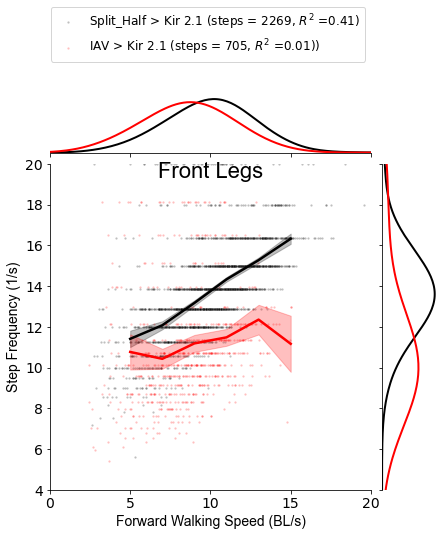

C:\Users\pratt\AppData\Local\Temp\ipykernel_12428\3585425369.py:62: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


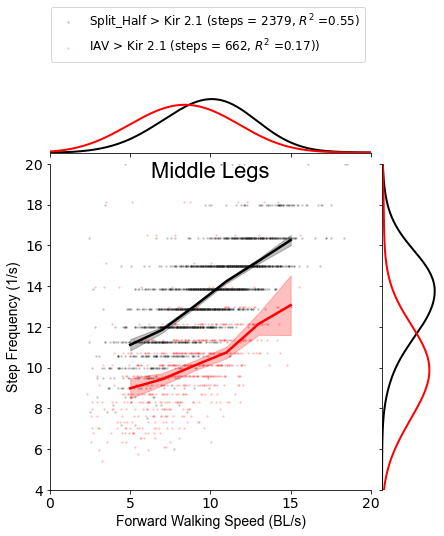

C:\Users\pratt\AppData\Local\Temp\ipykernel_12428\3585425369.py:62: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


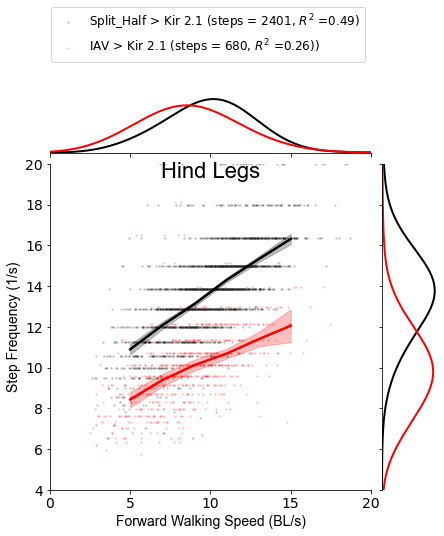

In [45]:
# plot parameters
plot_metric = step_freq_comparison
p_coeff = 1
plot_scatter = True
ylabel_name = 'Step Frequency (1/s)'
metric_name = 'step_freq'
ylim = [4,20]
add_offset = True 
offset_val = 0.125
plot_marginal_intralimb_comparison(plot_metric, p_coeff, plot_scatter, ylabel_name, metric_name, ylim, add_offset, offset_val)

C:\Users\pratt\AppData\Local\Temp\ipykernel_12428\3585425369.py:62: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


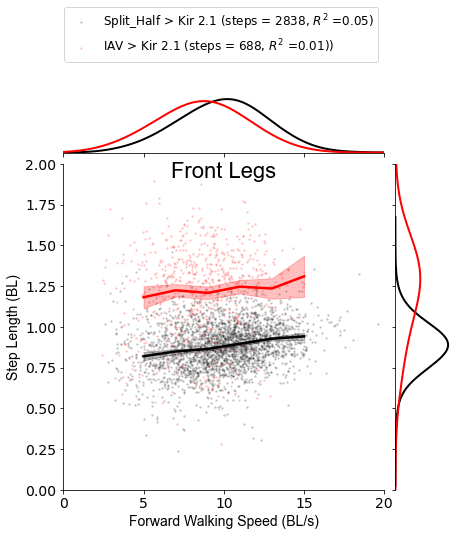

C:\Users\pratt\AppData\Local\Temp\ipykernel_12428\3585425369.py:62: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


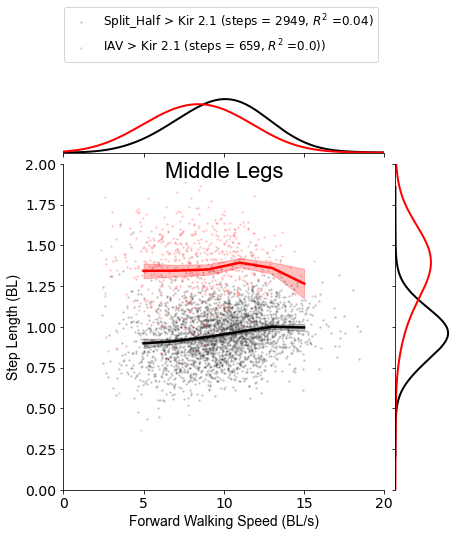

C:\Users\pratt\AppData\Local\Temp\ipykernel_12428\3585425369.py:62: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


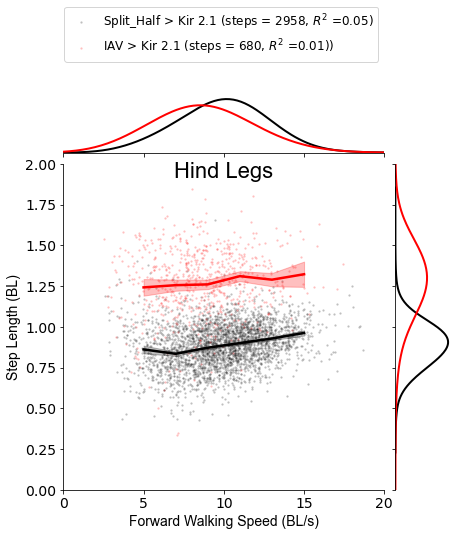

In [44]:
# plot parameters - STEP LENGTH
plot_metric = step_distance_comparison
p_coeff = 1
plot_scatter = True
ylabel_name = 'Step Length (BL)'
metric_name = 'step_length'
ylim = [0,2]
add_offset = False
offset_val = 0.125
plot_marginal_intralimb_comparison(plot_metric, p_coeff, plot_scatter, ylabel_name, metric_name, ylim, add_offset, offset_val)

### Number of legs in stance

In [114]:
# edges of distributions
vel_bins = 6
# vel_grid = np.linspace(np.min(fw_vel), np.max(fw_vel), vel_bins)
vel_grid = np.linspace(2, 18, vel_bins)
vel_center = np.around(vel_grid[1::] - (vel_grid[1]-vel_grid[0]),2)

# compute probability distribution for each of the nleg categories
nleg_prob = np.zeros((7, len(vel_center), len(nlegs_stance_walking_compare)))

for g in range(len(nlegs_stance_walking_compare)):
    speed_dist = parallel_vel_compare[g].flatten()
    nlegs_dist = nlegs_stance_walking_compare[g].flatten()

    beh_ids = beh_class_compare[g].flatten()

    # isolate forward walking
    fw_nlegs = nlegs_dist[beh_ids==1]
    fw_vel = speed_dist[beh_ids==1]

    # filter nlegs - remove nans
    fw_vel = fw_vel[~np.isnan(fw_nlegs)]
    fw_nlegs = fw_nlegs[~np.isnan(fw_nlegs)]
    nleg_cat = np.unique(fw_nlegs)
    print(len(fw_nlegs))

    for j in range(7):
        leg_idxs = np.where(fw_nlegs == nleg_cat[j])[0]
        for i in range(len(vel_center)):
            nleg_vels = fw_vel[leg_idxs]
            nleg_prob[j,i,g] = len(np.where(np.logical_and(nleg_vels>=vel_grid[i], nleg_vels<=vel_grid[i+1])==True)[0])

    nleg_prob[:,:,g] = nleg_prob[:,:,g]/np.sum(nleg_prob[:,:,g], axis = 0)

23958
11080


In [113]:
gen_nlegs_store = []
for g in range(len(nlegs_stance_walking_compare)):
    uflies = np.unique(meta_matrix_compare[g][:,0]).astype(int).tolist()
    nleg_prob_fly = np.zeros((len(uflies), len(vel_center), 7))
    for fly in uflies:
        f_idxs = np.where(meta_matrix_compare[g][:,0] == fly)[0]
        speed_dist = parallel_vel_compare[g][f_idxs,:].flatten()
        nlegs_dist = nlegs_stance_walking_compare[g][f_idxs,:].flatten()

        beh_ids = beh_class_compare[g][f_idxs,:].flatten()

        # isolate forward walking
        fw_nlegs = nlegs_dist[beh_ids==1]
        fw_vel = speed_dist[beh_ids==1]

        # filter nlegs - remove nans
        fw_vel = fw_vel[~np.isnan(fw_nlegs)]
        fw_nlegs = fw_nlegs[~np.isnan(fw_nlegs)]
        
        for i in range(len(vel_center)):
            tot_count = 0
            for j in range(7):
                leg_idxs = np.where(fw_nlegs == nleg_cat[j])[0]
                nleg_vels = fw_vel[leg_idxs]
                nleg_prob_fly[fly-1,i,j] = len(np.where(np.logical_and(nleg_vels>=vel_grid[i], nleg_vels<=vel_grid[i+1])==True)[0])
                tot_count += len(np.where(np.logical_and(nleg_vels>=vel_grid[i], nleg_vels<=vel_grid[i+1])==True)[0])
            if tot_count > 5:
                nleg_prob_fly[fly-1,i,:] = nleg_prob_fly[fly-1,i,:]/tot_count
            else:
                nleg_prob_fly[fly-1,i,:] = np.nan
    
    gen_nlegs_store.append(nleg_prob_fly)

454
957
1413
631
1104
2986
2440
2651
6840
4482
1060
167
584
2223
2301
110
822
770
1462
1581


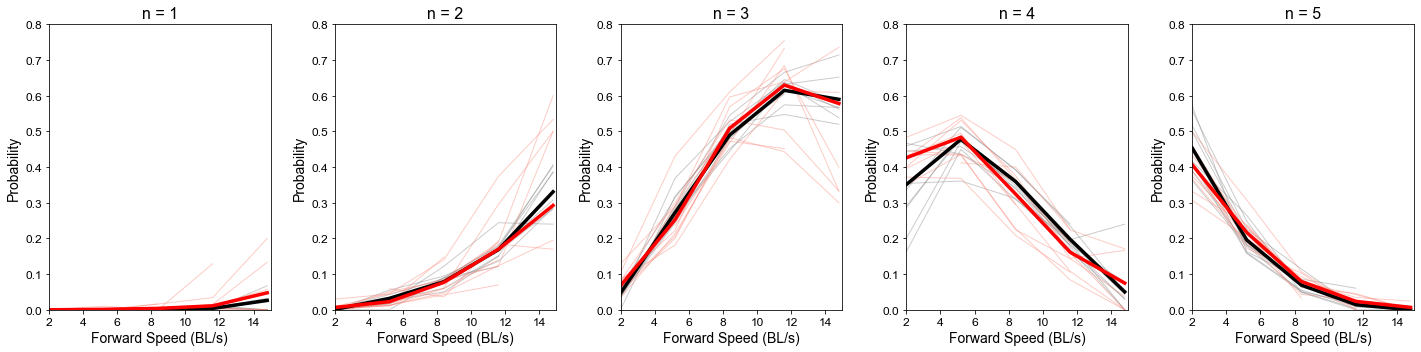

In [110]:
# plot distrbutions
fig = plt.figure(1, figsize = [20,5])

for j in range(5):
    plt.subplot(1,5,j+1)
    plt.plot(vel_center, nleg_prob[j+1,:,0], color ='black', linewidth = 3.5, zorder= 2)
    for i in range(gen_nlegs_store[0].shape[0]):
        plt.plot(vel_center, gen_nlegs_store[0][i,:,j+1], color = 'gray', linewidth = 1, zorder = 1, alpha = 0.4)
    
    plt.plot(vel_center, nleg_prob[j+1,:,1], color ='red', linewidth = 3.5, alpha = 1, zorder = 2)
    for i in range(gen_nlegs_store[1].shape[0]):
        plt.plot(vel_center, gen_nlegs_store[1][i,:,j+1], color = 'salmon', linewidth = 1, zorder = 1, alpha = 0.4)
    
    plt.title('n = ' +str(j+1), fontsize = 16, fontname = 'Arial')
    plt.yticks(fontsize = 12, fontname = 'Arial')
    plt.xticks(fontsize = 12, fontname = 'Arial')
    plt.xlim([2, 15])
    plt.ylim([0, 0.8])
    plt.ylabel('Probability', fontsize = 14, fontname = 'Arial')
    plt.xlabel('Forward Speed (BL/s)', fontsize = 14, fontname = 'Arial')
    
plt.tight_layout()
plt.show()
    
fig.savefig(figure_dir +'nleg_stance_compare.png', dpi = 300)
fig.savefig(figure_dir +'nleg_stance_compare.svg', dpi = 300)